<a id='content_list'></a>
### 목차 이동
- <a href='#step_1'>1. 데이터 준비</a>
- <a href='#step_2'>2. 데이터 탐색</a>
    - <a href='#step_2_1'>2-1. 결측치, 중복값 확인</a>
    - <a href='#step_2_2'>2-2. 데이터 가공(도시명, 카테고리, 아이템 추출)</a>
        - <a href='#step_city'>도시명</a>
        - <a href='#step_shop_type'>상점타입</a>
        - <a href='#step_label_enc_city_shop'>라벨 인코딩 - 도시, 상점</a>
        - <a href='#step_cat_lv'>카테고리 세분화</a>
        - <a href='#step_label_enc_cat'>라벨 인코딩 - 카테고리</a>
        - <a href='#step_item'>아이템</a>
            - <a href='#step_item_first'>첫 판매월 추가</a>
        - <a href='#step_df_le'>df에서 숫자(id)만 추출</a>
        - <a href='#step_no_test_no_train'>no_test_no_train</a>
- <a href='#step_3'>3. 데이터 병합</a>
    - <a href='#step_base_df'>기본 데이터 프레임 만들기</a>
    - <a href='#step_outlier'>이상치 제거</a>
        - <a href='#step_outlier_item_cnt_day'>item_cnt_day</a>
        - <a href='#step_outlier_item_price'>item_price</a>
    - <a href='#step_new_feature'>Feature 생성</a>
        - <a href='#step_df_basis_monthly'>df_basis_monthly</a>
            - <a href='#step_basis_monthly_outlier'>이상치 미처리</a>
        - <a href='#step_df_basis_discount'>df_basis_discount</a>
        - <a href='#step_df_basis_city_cat_y_m'>df_basis_city_cat_y_m</a>
    - <a href='#step_eda'>EDA</a>
        - <a href='#step_monthly_cnt'>월별 총 판매량</a>
        - <a href='#step_yearly_cnt'>1년주기 총 판매량</a>
        - <a href='#step_city_cnt'>도시별 총 판매량</a>
        - <a href='#step_cat_lv1_cnt'>카테고리(대분류)별 총 판매량</a>
        - <a href='#step_cat_lv2_cnt'>카테고리(중분류)별 총 판매량</a>
        - <a href='#step_corr'>상관관계 분석</a>
- <a href='#step_4_1'>4. 피처 엔지니어링</a>
    - <a href='#step_new_item'>신상여부 </a>
- <a href='#step_5'>5. 모델링</a>
    - <a href='#step_5_1'>5-1. train, validation, test set으로 구분 짓기</a>
    - <a href='#step_linear_km'>Linear Regression</a>
    - <a href='#step_knn_sy'>KNN</a>
    - <a href='#step_rf_hy'>Random Forest</a>
    - <a href='#step_xgboost_jy'>XGBoost</a>
    - <a href='#step_lgbm_dy'>LightBGM</a>
- <a href='#step_6'>6. 앙상블</a>

라이브러리 설치

In [1]:
# # xgboost 라이브러리 설
# !pip install xgboost

# # category_encoders 라이브러리 설치
# !pip install category_encoders

# # lightgbm 라이브러리 설치
# !pip install lightgbm

모듈 불러오기

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import product
from sklearn.preprocessing import LabelEncoder

from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import ensemble, metrics
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from xgboost import plot_importance
import lightgbm as lgb
from sklearn.linear_model import LinearRegression

작업 환경 셋팅

In [3]:
# 오류 무시
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

# 자연상수 e 없이 나오게
# pd.options.display.float_format = '{:,f}'.format
pd.options.display.float_format = '{:,.3f}'.format  # 소숫점 3자리

pd.set_option('display.max_rows', None)  # 모든 행 보이기
# pd.set_option('display.max_rows', 60)  # 일부 행만 보이기, default : 60

pd.set_option('display.max_columns', None)  # 모든 열 보이기
# pd.set_option('display.max_columns', 20)  # 일부 열만 보이기, default : 20

# 마이너스 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

# 한글폰트
# plt.rc('font', family='Malgun Gothic')  # batang, gulim

# 애플 한글폰트
from matplotlib import rc
rc('font', family='AppleGothic')

In [4]:
# 메모리 최적화

def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                #if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                #    df[col] = df[col].astype(np.float16)
                #el
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        #else:
            #df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB --> {:.2f} MB (Decreased by {:.1f}%)'.format(
        start_mem, end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [5]:
# 안쓰는 메모리 삭제

import gc

# del group
# gc.collect();

<a id='step_1' href='#content_list'>목차로</a>
## 1. 데이터 준비

In [6]:
path = './data/'

cat = pd.read_csv(path + 'item_categories.csv')
items = pd.read_csv(path + 'items.csv')
shops = pd.read_csv(path + 'shops.csv')
train = pd.read_csv(path + 'sales_train.csv')
test = pd.read_csv(path + 'test.csv') 
submission = pd.read_csv(path + 'sample_submission.csv')

In [7]:
# train 날짜 형식 변경 : 02.01.2013  >>  2013-01-02
train['date'] = pd.to_datetime(train['date'], format='%d.%m.%Y')

<a id='step_2' href='#content_list'>목차로</a>
## 2. 데이터 탐색

<a id='step_2_1' href='#content_list'>목차로</a>
### 2-1. 결측치, 중복값 확인

##### 결측치 확인

In [8]:
# 결측치 확인
print(train.info())
print()
print(train.isnull().sum())
print()
print(cat.isnull().sum())
print()
print(items.isnull().sum())
print()
print(shops.isnull().sum())

# train - date 값 확인
print('Min date from train set: %s' % train['date'].min().date())
print('Max date from train set: %s' % train['date'].max().date())
print()

# train - date_block_num 값 확인
print(train['date_block_num'].min())
print(train['date_block_num'].max())
print()

# train data 확인
print(train.describe())
print()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int64         
 2   shop_id         int64         
 3   item_id         int64         
 4   item_price      float64       
 5   item_cnt_day    float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB
None

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

item_category_name    0
item_category_id      0
dtype: int64

item_name           0
item_id             0
item_category_id    0
dtype: int64

shop_name    0
shop_id      0
dtype: int64
Min date from train set: 2013-01-01
Max date from train set: 2015-10-31

0
33

       date_block_num       shop_id       item_id    item_price  item_cnt_day
count   2,935,849.000 2,935,849.000 2,935,849.0

##### 중복 데이터 확인 및 삭제

In [9]:
# train >> 중복 데이터 6개 확인
print(train.duplicated().value_counts())
print()
print(train[train.duplicated() == True])
print()

# 중복 데이터 삭제
print(train.shape)
train.drop_duplicates(inplace =True)
print(train.shape)

False    2935843
True           6
dtype: int64

              date  date_block_num  shop_id  item_id  item_price  item_cnt_day
76962   2013-01-05               0       54    20130     149.000         1.000
1435367 2014-02-23              13       50     3423     999.000         1.000
1496766 2014-03-23              14       21     3423     999.000         1.000
1671873 2014-05-01              16       50     3423     999.000         1.000
1866340 2014-07-12              18       25     3423     999.000         1.000
2198566 2014-12-31              23       42    21619     499.000         1.000

(2935849, 6)
(2935843, 6)


In [10]:
# 그 외 중복 데이터 확인
print(cat.duplicated().sum())
print(sum(items.duplicated()))
print(sum(shops.duplicated()))

0
0
0


<a id='step_2_2' href='#content_list'>목차로</a>
### 2-2. 데이터 가공

<a id='step_city' href='#content_list'>목차로</a>
#### 상점명에서 도시 이름 추출

In [11]:
shops
# ! 있음 : 0, 1
# Сергиев Посад 세르기예프 포사트 : 46
# Интернет-магазин ЧС 인터넷-(상점명) ЧС : 12
# Цифровой склад 1С-Онлайн 디지털 창고 1C-온라인: 55
# ТЦ , ТРЦ , МТРЦ , ТК , ТРК : 쇼핑몰, 쇼핑센터 등 을 뜻하는 약어, 두번째열에 있음

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6
7,"Воронеж ТРЦ ""Максимир""",7
8,"Воронеж ТРЦ Сити-Парк ""Град""",8
9,Выездная Торговля,9


In [12]:
# 조작용 shops 깊은복사 만들기
df_shop = shops.copy()

# 도시명 분리 전처리
# ! 제거
df_shop['shop_name'] = df_shop['shop_name'].str.replace('!', '')

# - 제거 
df_shop['shop_name'] = df_shop['shop_name'].str.replace('Интернет-', 'Интернет ')

# 도시명 띄어쓰기 >> 붙이기
df_shop['shop_name'] = df_shop['shop_name'].str.replace('Сергиев Посад', 'СергиевПосад')

# 도시명 분리 : 첫번째 띄어쓰기
df_shop['city'] = df_shop['shop_name'].str.split(' ').map(lambda x:x[0])

print(df_shop.head())

                        shop_name  shop_id      city
0    Якутск Орджоникидзе, 56 фран        0    Якутск
1    Якутск ТЦ "Центральный" фран        1    Якутск
2                Адыгея ТЦ "Мега"        2    Адыгея
3  Балашиха ТРК "Октябрь-Киномир"        3  Балашиха
4        Волжский ТЦ "Волга Молл"        4  Волжский


<a id='step_shop_type' href='#content_list'>목차로</a>
##### 상점 타입 생성

In [13]:
# shop_type 생성
df_shop['shop_type'] = np.nan

# 쇼핑몰, 온라인, 기타 분리 : 두번째 띄어쓰기
# ТЦ , ТРЦ , МТРЦ , ТК , ТРК : 쇼핑몰  >>  mall_x
# Интернет, Цифровой : 온라인  >>  online
# 기타  >>  store

for i in range(len(df_shop)):
    tmp_city = df_shop['city'][i]
    tmp_1 = df_shop['shop_name'][i].split(' ')[1]
    val = ''
    
    if (tmp_1 == 'ТЦ'):
        val = 'mall_1'
    elif (tmp_1 == 'ТРЦ'):
        val = 'mall_2'
    elif (tmp_1 == 'МТРЦ'):
        val = 'mall_3'
    elif (tmp_1 == 'ТК'):
        val = 'mall_4'
    elif (tmp_1 == 'ТРК'):
        val = 'mall_5'
        
    elif (tmp_city == 'Интернет') | (tmp_city == 'Цифровой'):
        val = 'online'
    else :
        val = 'store'
        
    df_shop.iloc[i, 3] = val
#     print(i ,tmp)

print(df_shop)

                                          shop_name  shop_id          city  \
0                      Якутск Орджоникидзе, 56 фран        0        Якутск   
1                      Якутск ТЦ "Центральный" фран        1        Якутск   
2                                  Адыгея ТЦ "Мега"        2        Адыгея   
3                    Балашиха ТРК "Октябрь-Киномир"        3      Балашиха   
4                          Волжский ТЦ "Волга Молл"        4      Волжский   
5                            Вологда ТРЦ "Мармелад"        5       Вологда   
6                        Воронеж (Плехановская, 13)        6       Воронеж   
7                            Воронеж ТРЦ "Максимир"        7       Воронеж   
8                      Воронеж ТРЦ Сити-Парк "Град"        8       Воронеж   
9                                 Выездная Торговля        9      Выездная   
10                       Жуковский ул. Чкалова 39м?       10     Жуковский   
11                       Жуковский ул. Чкалова 39м²       11    

<a id='step_label_enc_city_shop' href='#content_list'>목차로</a>
##### 라벨 인코딩 - 도시, 상점

In [14]:
# 라벨 인코딩  >>  city_id, shop_type_id
le = LabelEncoder() 

# city_id
list_tmp = list(df_shop['city'].values)
le.fit(list_tmp)
df_shop['city_id'] = le.transform(list_tmp)

# shop_type_id
list_tmp = list(df_shop['shop_type'].values)
le.fit(list_tmp)
df_shop['shop_type_id'] = le.transform(list_tmp)

df_shop = df_shop[['shop_name', 'shop_id', 'city', 'city_id', 'shop_type', 'shop_type_id']]

print(df_shop.head())
print()
print(df_shop.info())

                        shop_name  shop_id      city  city_id shop_type  \
0    Якутск Орджоникидзе, 56 фран        0    Якутск       29     store   
1    Якутск ТЦ "Центральный" фран        1    Якутск       29    mall_1   
2                Адыгея ТЦ "Мега"        2    Адыгея        0    mall_1   
3  Балашиха ТРК "Октябрь-Киномир"        3  Балашиха        1    mall_5   
4        Волжский ТЦ "Волга Молл"        4  Волжский        2    mall_1   

   shop_type_id  
0             6  
1             0  
2             0  
3             4  
4             0  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   shop_name     60 non-null     object
 1   shop_id       60 non-null     int64 
 2   city          60 non-null     object
 3   city_id       60 non-null     int32 
 4   shop_type     60 non-null     object
 5   shop_type_id  60 non-null     int32 
dt

<a id='step_cat_lv' href='#content_list'>목차로</a>
#### Item Category 세분화(파생 변수)

In [15]:
df_cat = cat.copy()
print(df_cat.head())

# 0 PC - Гарнитуры/Наушники PC용 헤드셋  >> 악세사리
# 1 ~ 7 Аксессуары 악세사리
# 8 Билеты 티켓
# 9 Доставка товара 상품배송
# 10 ~ 17 Игровые консоли 게임콘솔
# 18 ~ 31 Игры 게임
# 32 ~ 36 Карты оплаты 결제카드
# 37 ~ 41 Кино 영화
# 42 ~ 54 Книги 책
# 55 ~ 60 Музыка 음악
# 61 ~ 72 Подарки 선물
# 73 ~ 78 Программы  프로그램
# 79 Служебные 서비스
# 80 Служебные - Билеты 서비스 - 티켓
# 81 Чистые носители (шпиль) 공미디어 (여러장 들어있는 통?)
# 82 Чистые носители (штучные) 공미디어 (윗면 종이? 윗면 프린트?)
# 83 Элементы питания 배터리

        item_category_name  item_category_id
0  PC - Гарнитуры/Наушники                 0
1         Аксессуары - PS2                 1
2         Аксессуары - PS3                 2
3         Аксессуары - PS4                 3
4         Аксессуары - PSP                 4


In [16]:
# 아이템 카테고리 이름 번역 및 데이터 정리
df_cat['cat_eng'] = np.nan

# ' - ' 로 1단계 ~ 3단계 구분
# Цифра  >>  Number  >>  (0) 으로 표시
# (-1) : 해당 단계의 정보 없음. 예) 2단계에 (-1) 이 있으면 1단계 정보만 있음

for i in range(0, 8):
    tmp = df_cat['item_category_name'][i].split(' - ')[1]
    if tmp == 'Гарнитуры/Наушники' : tmp = 'PC Headsets/Headphones'
    df_cat.iloc[i, 2] = 'Accessories'+' - '+tmp
    
for i in range(8, 9):
    tmp = df_cat['item_category_name'][i].split(' ')[1]
    tmp = tmp.replace('(Цифра)', ' (number)')
    df_cat.iloc[i, 2] = 'Tickets'+' - '+tmp
    
for i in range(9, 10):
    tmp = '(-1)'
    df_cat.iloc[i, 2] = 'Delivery of goods'+' - '+tmp
    
for i in range(10, 18):
    tmp = df_cat['item_category_name'][i].split(' - ')[1]
    if tmp == 'Прочие' : tmp = 'Other'
    df_cat.iloc[i, 2] = 'Game consoles'+' - '+tmp
    
for i in range(18, 26):
    tmp = df_cat['item_category_name'][i].split(' - ')[1]
    if tmp == 'Аксессуары для игр' : tmp = 'Game accessories'
    df_cat.iloc[i, 2] = 'Games'+' - '+tmp
    
for i in range(26, 32):
    tmp = df_cat['item_category_name'][i].split(' ')[1]
    val = 'Games'+' - '+tmp
    
    tmp = df_cat['item_category_name'][i].split(' - ')[1]
    if tmp == 'Цифра' :
        tmp = '(number)'
    elif tmp.find('Дополнительные') != -1:
        tmp = 'Additional editions'
    elif tmp.find('Коллекционные') != -1:
        tmp = "Collector's editions"
    elif tmp.find('Стандартные') != -1:
        tmp = 'Standard editions'
    val = val +' - '+ tmp
    
    df_cat.iloc[i, 2] = val
    
for i in range(32, 33):
    tmp = 'Movie, Music, Games'
    df_cat.iloc[i, 2] = 'Payment cards'+' - '+tmp
    
for i in range(33, 37):
    tmp = df_cat['item_category_name'][i].split(' - ')[1]
    tmp = tmp.replace('(Цифра)', '- (number)')
    df_cat.iloc[i, 2] = 'Payment cards'+' - '+tmp
    
for i in range(37, 42):
    tmp = df_cat['item_category_name'][i].split(' - ')[1]
    
    tmp = tmp.replace(' ', ' - ')
    tmp = tmp.replace('Коллекционное', 'Collectible')
    
    df_cat.iloc[i, 2] = 'Movie'+' - '+tmp
    
for i in range(42, 55):
    tmp = df_cat['item_category_name'][i].split(' - ')[1]
    
    tmp = tmp.replace('Артбуки', 'Artbooks')
    tmp = tmp.replace('энциклопедии', 'encyclopedias')
    tmp = tmp.replace('Аудиокниги', 'Audiobook')
    tmp = tmp.replace('Бизнес литература', 'business literature')
    tmp = tmp.replace('Комиксы', 'Comics')
    tmp = tmp.replace('манга', 'manga')
    tmp = tmp.replace('Компьютерная литература', 'computer literature')
    tmp = tmp.replace('Методические материалы', 'Methodical materials')
    tmp = tmp.replace('Открытки', 'Postcards')
    tmp = tmp.replace('Познавательная литература', 'Educational literature')
    tmp = tmp.replace('Путеводители', 'Guides')
    tmp = tmp.replace('Художественная литература', 'Fiction')
    tmp = tmp.replace('(Цифра)', ' - (number)')
    tmp = tmp.replace('Цифра', ' (number)')
    tmp = tmp.replace('1С', ' - 1C')
#     tmp = tmp.replace(' ', ' - ')
    
    df_cat.iloc[i, 2] = 'Books'+' - '+tmp
    
for i in range(55, 61):
    tmp = df_cat['item_category_name'][i].split(' - ')[1]
    
    if tmp.find('CD') != -1:
        tmp = tmp.split(' ')[0] + tmp[3:]
        
    tmp = tmp.replace('локального производства', ' - local production')
    tmp = tmp.replace('фирменного производства', ' - branded production')
    tmp = tmp.replace('Винил', 'Vinyl Record')
    tmp = tmp.replace('Музыкальное видео', 'Music video')
    tmp = tmp.replace('Подарочные издания', 'Gift editions')
    
    df_cat.iloc[i, 2] = 'Music'+' - '+tmp
    
for i in range(61, 73):
    tmp = df_cat['item_category_name'][i].split(' - ')[1]
        
    tmp = tmp.replace('Атрибутика', 'Attributes')
    tmp = tmp.replace('Гаджеты', 'Gadgets')
    tmp = tmp.replace('роботы', 'robots')
    tmp = tmp.replace('спорт', 'sports')
    tmp = tmp.replace('Мягкие игрушки', 'Stuffed Toys')
    tmp = tmp.replace('Настольные игры', 'Board games')
    tmp = tmp.replace('(компактные)', '- compact')
    tmp = tmp.replace('Открытки', 'Postcards')
    tmp = tmp.replace('наклейки', 'stickers')
    tmp = tmp.replace('Развитие', 'Development')
    tmp = tmp.replace('Сертификаты', 'Certificates')
    tmp = tmp.replace('услуги', 'services')
    tmp = tmp.replace('Сувениры', 'Souvenirs')
    tmp = tmp.replace('(в навеску)', '- in a hitch')
    tmp = tmp.replace('Сумки', 'bags')
    tmp = tmp.replace('Альбомы', 'Albums')
    tmp = tmp.replace('Коврики д/мыши', 'mouse pads')
    tmp = tmp.replace('Фигурки', 'Figurines')
    
    df_cat.iloc[i, 2] = 'Gift'+' - '+tmp
    
for i in range(73, 79):
    tmp = df_cat['item_category_name'][i].split(' - ')[1]
    
    tmp = tmp.replace('1С:Предприятие', '1C: Enterprise')
    tmp = tmp.replace('Для дома и офиса', 'For home and office')
    tmp = tmp.replace('Обучающие', 'Educational')
    tmp = tmp.replace('(Цифра)', '- (number)')
    
    df_cat.iloc[i, 2] = 'Programs'+' - '+tmp
    
for i in range(79, 80):
    tmp = '(-2)'
    df_cat.iloc[i, 2] = 'Service'+' - '+tmp
    
for i in range(80, 81):
    tmp = df_cat['item_category_name'][i].split(' - ')[1]
    tmp = tmp.replace('Билеты', 'Tickets')
    df_cat.iloc[i, 2] = 'Service'+' - '+tmp
    
for i in range(81, 83):
    tmp = df_cat['item_category_name'][i].split(' (')[1]
    
    tmp = tmp.replace('шпиль)', 'spire')
    tmp = tmp.replace('штучные)', 'artificial')
    
    df_cat.iloc[i, 2] = 'Blank media'+' - '+tmp
    
for i in range(83, 84):
    tmp = '(-3)'
    df_cat.iloc[i, 2] = 'Batteries'+' - '+tmp
    
    
df_cat.head()

,item_category_name,item_category_id,cat_eng
0,PC - Гарнитуры/Наушники,0,Accessories - PC Headsets/Headphones
1,Аксессуары - PS2,1,Accessories - PS2
2,Аксессуары - PS3,2,Accessories - PS3
3,Аксессуары - PS4,3,Accessories - PS4
4,Аксессуары - PSP,4,Accessories - PSP


In [17]:
# 대분류, 중분류, 소분류 생성
# lv1 : '-' 으로 잘라서 첫번째
# lv2 : '-' 으로 잘라서 두번째 까지
# lv3 : '-' 으로 잘라서 세번째 까지, 세번째가 없으면 lv2와 같이 두번째 까지

df_cat['lv1'] = df_cat['cat_eng'].str.split(' - ').map(lambda x:x[0])
df_cat['lv2'] = df_cat['lv1'] +' - '+ df_cat['cat_eng'].str.split(' - ').map(lambda x:x[1])
df_cat['lv3'] = df_cat['cat_eng'].str.split(' - ').map(
    lambda x: x[0] +' - '+ x[1] +' - '+ x[2] if len(x) >= 3 else x[0] +' - '+ x[1]
)

df_cat.head()

,item_category_name,item_category_id,cat_eng,lv1,lv2,lv3
0,PC - Гарнитуры/Наушники,0,Accessories - PC Headsets/Headphones,Accessories,Accessories - PC Headsets/Headphones,Accessories - PC Headsets/Headphones
1,Аксессуары - PS2,1,Accessories - PS2,Accessories,Accessories - PS2,Accessories - PS2
2,Аксессуары - PS3,2,Accessories - PS3,Accessories,Accessories - PS3,Accessories - PS3
3,Аксессуары - PS4,3,Accessories - PS4,Accessories,Accessories - PS4,Accessories - PS4
4,Аксессуары - PSP,4,Accessories - PSP,Accessories,Accessories - PSP,Accessories - PSP


<a id='step_label_enc_cat' href='#content_list'>목차로</a>
##### 라벨 인코딩 - 카테고리

In [18]:
# 라벨 인코딩  >>  lv1, lv2, lv3
le = LabelEncoder() 

# lv1
list_tmp = list(df_cat['lv1'].values)
le.fit(list_tmp)
df_cat['lv1_id'] = le.transform(list_tmp)

# lv2
list_tmp = list(df_cat['lv2'].values)
le.fit(list_tmp)
df_cat['lv2_id'] = le.transform(list_tmp)

# lv3
list_tmp = list(df_cat['lv3'].values)
le.fit(list_tmp)
df_cat['lv3_id'] = le.transform(list_tmp)

print(df_cat.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   item_category_name  84 non-null     object
 1   item_category_id    84 non-null     int64 
 2   cat_eng             84 non-null     object
 3   lv1                 84 non-null     object
 4   lv2                 84 non-null     object
 5   lv3                 84 non-null     object
 6   lv1_id              84 non-null     int32 
 7   lv2_id              84 non-null     int32 
 8   lv3_id              84 non-null     int32 
dtypes: int32(3), int64(1), object(5)
memory usage: 5.0+ KB
None


<a id='step_item' href='#content_list'>목차로</a>
#### items 정리

In [19]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [20]:
df_item = items.copy()

<a id='step_item_first' href='#content_list'>목차로</a>
##### 첫 판매월 추가


In [21]:
df_item['item_first'] = train.groupby('item_id').agg({'date_block_num':'min'})['date_block_num']
df_item['item_first'].head()

0   20.000
1   15.000
2   19.000
3   18.000
4   20.000
Name: item_first, dtype: float64

In [22]:
# NaN >> 34 (34월에 처음 팔린 것으로 보고 결측값 처리)
df_item['item_first'] = df_item['item_first'].fillna(34)
df_item['item_first'] = df_item['item_first'].astype('int')
print(df_item['item_first'].head())
print()
print(df_item.info())

0    20
1    15
2    19
3    18
4    20
Name: item_first, dtype: int32

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   item_name         22170 non-null  object
 1   item_id           22170 non-null  int64 
 2   item_category_id  22170 non-null  int64 
 3   item_first        22170 non-null  int32 
dtypes: int32(1), int64(2), object(1)
memory usage: 606.3+ KB
None


<a id='step_df_le' href='#content_list'>목차로</a>
#### 숫자형 데이터만 추출
- df_shop_num, df_cat_num, df_item_num

In [23]:
# 상점
df_shop_num = df_shop[['shop_id', 'city_id', 'shop_type_id']]
print(df_shop_num.head())
print()
print(df_shop_num.info())

# 카테고리
df_cat_num = df_cat[['item_category_id', 'lv1_id', 'lv2_id', 'lv3_id']]
print(df_cat_num.head())
print()
print(df_cat_num.info())

# 아이템
df_item_num = df_item[['item_id', 'item_category_id','item_first']]
print(df_item_num.head())
print()
print(df_item_num.info())

   shop_id  city_id  shop_type_id
0        0       29             6
1        1       29             0
2        2        0             0
3        3        1             4
4        4        2             0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   shop_id       60 non-null     int64
 1   city_id       60 non-null     int32
 2   shop_type_id  60 non-null     int32
dtypes: int32(2), int64(1)
memory usage: 1.1 KB
None
   item_category_id  lv1_id  lv2_id  lv3_id
0                 0       0       0       0
1                 1       0       1       1
2                 2       0       2       2
3                 3       0       3       3
4                 4       0       4       4

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype
---  ------            

<a id='step_no_test_no_train' href='#content_list'>목차로</a>
##### test 에 없는 상점, 상품은 train 에서  제거
- 제거 되는 상품중에 test 에 있는 상품과 연관성이 없는 것이 확실할까?

In [24]:
df_test = test.copy()
df_test['date_block_num'] = 34
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   ID              214200 non-null  int64
 1   shop_id         214200 non-null  int64
 2   item_id         214200 non-null  int64
 3   date_block_num  214200 non-null  int64
dtypes: int64(4)
memory usage: 6.5 MB


In [25]:
df_train = train.copy()
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2935843 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int64         
 2   shop_id         int64         
 3   item_id         int64         
 4   item_price      float64       
 5   item_cnt_day    float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 156.8 MB


In [26]:
print(len(df_test['shop_id'].unique()))
print(df_test['item_id'].nunique())

42
5100


In [27]:
print(len(df_train['shop_id'].unique()))
print(df_train['item_id'].nunique())

60
21807


In [28]:
len(set(df_test['item_id']) - set(df_train['item_id']))
# 363개는 0값 처리해야함... 엥? 다시 돌리니 384개가 나오네

363

In [29]:
test_only_shop = df_test['shop_id'].unique()  # test 에만 있는 shop_id
test_only_item = df_test['item_id'].unique()  # test 에만 있는 item_id

# train 에서 test 에 있는 것 만 남김  >>  test 에 없는 것은 train 에서 삭제
df_train = df_train[df_train['shop_id'].isin(test_only_shop)]
df_train = df_train[df_train['item_id'].isin(test_only_item)]

print(df_train['shop_id'].nunique())
print(df_train['item_id'].nunique())

print('df_train:', df_train.shape)

# test의 item_id는 5100가지 인데 train의 item_id는 4716가지가 남음
# >>  차이 384가지는 train에 없어서 학습이 안됨

42
4716
df_train: (1224434, 6)


<a id='step_3' href='#content_list'>목차로</a>
## 3. 데이터 병합
- Baseline 모델 만들기
- 자료형 변환 필요 *******
- item_price 아이템 가격 처리 

<a id='step_base_df' href='#content_list'>목차로</a>
### 3-1. 기본 데이터 프레임 만들기
- date_block_num, shop_id, item_id 의 모든 경우의 수
- test에 없는 데이터는 삭제한 train 데이터와 합침

In [30]:
# test 에만 있는 shop_id
test_shops = df_test['shop_id'].unique()

# test에만 있는 item_id
test_items = df_test['item_id'].unique()

# block_shop_combi = date_block_num * shop_id
# 34 * 42 = 1,428 행
df_block_shop_combi = pd.DataFrame(list(product(np.arange(34), test_shops)),
                                columns=['date_block_num','shop_id']
                               )

# shop_item_combi = shop_id * item_id
# 42 * 5100 = 214,200 행
df_shop_item_combi = pd.DataFrame(list(product(test_shops, test_items)),
                               columns=['shop_id','item_id']
                              )

# all_combi = block_shop_combi + shop_item_combi
# 34 * 42 * 5100 = 7,282,800 행

df_all_combi = pd.merge(df_block_shop_combi, df_shop_item_combi,
                     on=['shop_id'], how='inner')

print(df_all_combi.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7282800 entries, 0 to 7282799
Data columns (total 3 columns):
 #   Column          Dtype
---  ------          -----
 0   date_block_num  int32
 1   shop_id         int64
 2   item_id         int64
dtypes: int32(1), int64(2)
memory usage: 194.5 MB
None


In [31]:
# 중간 최적화
df_all_combi=reduce_mem_usage(df_all_combi)

del df_shop_item_combi

del df_block_shop_combi
gc.collect();

Memory usage of dataframe is 194.47 MB --> 83.35 MB (Decreased by 57.1%)


In [32]:
# 구) df_train_base_ext
# df_train_basis = 모든 월, 모든 상점, 모든 아이템 * train 데이터

df_train_basis = pd.merge(df_all_combi, df_train,
                          on = ['date_block_num','shop_id','item_id'],
                          how='left')

df_train_basis = pd.concat([df_train_basis, df_test], ignore_index=True, 
                       sort=False, keys=['date_block_num','shop_id','item_id'])
df_train_basis.fillna(0, inplace=True)  # 34month

df_train_basis.drop(columns=['ID'], inplace = True)

<a id='step_outlier' href='#content_list'>목차로</a>
### 3-2. 이상치 제거
- df_train_basis 에서 이상치가 다시 나와서, 위에서 한 작업들 다시 함

<a id='step_outlier_item_cnt_day' href='#content_list'>목차로</a>
#### item_cnt_day 이상치 처리

In [33]:
df_train_basis.sort_values('item_cnt_day', ascending=False).head(10)

,date_block_num,shop_id,item_id,date,item_price,item_cnt_day
1462518,33,12,11373,2015-10-28 00:00:00,0.909,"2,169.000"
1411924,24,12,20949,2015-01-15 00:00:00,4.000,"1,000.000"
1427815,27,12,3731,2015-04-14 00:00:00,"1,904.548",624.000
1434952,28,12,11373,2015-05-19 00:00:00,155.193,539.000
2219997,17,25,20949,2014-06-28 00:00:00,5.000,501.000
1461195,33,12,20949,2015-10-14 00:00:00,4.000,500.000
1406103,23,12,20949,2014-12-19 00:00:00,4.000,500.000
1433425,28,12,10209,2015-05-19 00:00:00,"1,499.000",480.000
2601653,14,24,20949,2014-03-15 00:00:00,5.000,405.000
1435047,28,12,11370,2015-05-19 00:00:00,171.662,343.000


In [34]:
condition = (df_item['item_id'] == 11373) | (df_item['item_id'] == 20949)
df_item[condition]

#2,169.000000	Доставка до пункта выдачи (Boxberry) 물품 배송
#1,000.000000	Фирменный пакет майка 1С Интерес белый  기업에 티셔츠 판매 

,item_name,item_id,item_category_id,item_first
11373,Доставка до пункта выдачи (Boxberry),11373,9,0
20949,Фирменный пакет майка 1С Интерес белый (34*42)...,20949,71,3


In [35]:
df_train_basis['item_cnt_day'].describe()

count   8,121,275.000
mean            0.199
std             1.371
min           -16.000
25%             0.000
50%             0.000
75%             0.000
max         2,169.000
Name: item_cnt_day, dtype: float64

In [36]:
#값이 큰 이상치 확인
df_train_basis['item_cnt_day'].nlargest(10)

1462518   2,169.000
1411924   1,000.000
1427815     624.000
1434952     539.000
2219997     501.000
1406103     500.000
1461195     500.000
1433425     480.000
2601653     405.000
1435047     343.000
Name: item_cnt_day, dtype: float64

findfont: Font family ['AppleGothic'] not found. Falling back to DejaVu Sans.


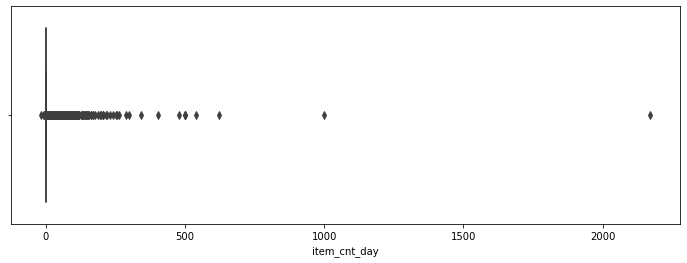

In [37]:
plt.figure(figsize = (12, 4))
sns.boxplot(x = df_train_basis['item_cnt_day'])
plt.show()

In [38]:
# 평균값과 차이가 크고 특정상품이 아니고 배송한 상품 갯수인
# 가장 큰 값 2,169 값 제거 
condition = df_train_basis['item_cnt_day'] < 2000
df_train_basis = df_train_basis[condition]

In [39]:
df_train_basis.sort_values('item_cnt_day', ascending=False).head(10)

,date_block_num,shop_id,item_id,date,item_price,item_cnt_day
1411924,24,12,20949,2015-01-15 00:00:00,4.000,"1,000.000"
1427815,27,12,3731,2015-04-14 00:00:00,"1,904.548",624.000
1434952,28,12,11373,2015-05-19 00:00:00,155.193,539.000
2219997,17,25,20949,2014-06-28 00:00:00,5.000,501.000
1461195,33,12,20949,2015-10-14 00:00:00,4.000,500.000
1406103,23,12,20949,2014-12-19 00:00:00,4.000,500.000
1433425,28,12,10209,2015-05-19 00:00:00,"1,499.000",480.000
2601653,14,24,20949,2014-03-15 00:00:00,5.000,405.000
1435047,28,12,11370,2015-05-19 00:00:00,171.662,343.000
3990769,27,42,3731,2015-04-14 00:00:00,"1,918.732",299.000


In [40]:
df_train_basis.shape

(8121274, 6)

In [41]:
#값이 작은 이상치 확인
df_train_basis['item_cnt_day'].nsmallest(10)

3556467   -16.000
3881413    -6.000
525283     -5.000
870518     -5.000
1337168    -4.000
2486129    -4.000
873335     -3.000
1330876    -3.000
1336207    -3.000
1351120    -3.000
Name: item_cnt_day, dtype: float64

In [42]:
condition = df_train_basis['item_cnt_day'] < 0
df_train_basis['item_cnt_day'][condition].value_counts().sum()

# 7,907,074 개 중 2941 개의 음수 값  
# 환불인 것인지, 잘못 기입한 것인지 모르므로

# 1 음수값 그대로 데이터 사용
# 2 음수값 삭제 후 데이터 사용
# 3 절대값으로 변경 후 데이터 사용

2941

<a id='step_outlier_item_price' href='#content_list'>목차로</a>
#### item_price 이상치 처리

In [43]:
df_train_basis['item_price'].describe()

# mean  1,030.667 -> 치우친 값 존재 
# 50%     549.000

count   8,121,274.000
mean          155.392
std           799.674
min             0.000
25%             0.000
50%             0.000
75%             0.000
max        59,200.000
Name: item_price, dtype: float64

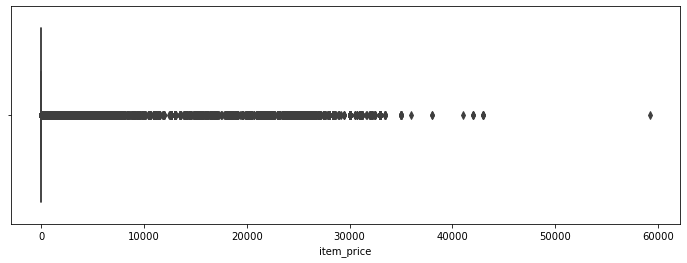

In [44]:
plt.figure(figsize = (12, 4))
sns.boxplot(x = df_train_basis['item_price'])
plt.show()

In [45]:
df_train_basis.sort_values(by='item_price', ascending=False).head(20)

,date_block_num,shop_id,item_id,date,item_price,item_cnt_day
1327233,8,12,11365,2013-09-17 00:00:00,"59,200.000",1.000
2524319,33,22,13403,2015-10-20 00:00:00,"42,990.000",1.000
736576,33,3,13403,2015-10-20 00:00:00,"42,990.000",1.000
1466073,33,12,13403,2015-10-29 00:00:00,"42,990.000",1.000
4035172,33,42,13403,2015-10-23 00:00:00,"42,990.000",1.000
3460016,33,18,13403,2015-10-22 00:00:00,"41,990.000",1.000
6821841,33,38,13403,2015-10-20 00:00:00,"41,990.000",1.000
1466072,33,12,13403,2015-10-20 00:00:00,"41,990.000",1.000
1682243,33,28,13403,2015-10-22 00:00:00,"40,991.000",1.000
2338380,33,25,13403,2015-10-26 00:00:00,"37,991.000",1.000


In [46]:
condition = (df_item['item_id'] == 11365) | (df_item['item_id'] == 13403) \
            | (df_item['item_id'] == 13503) | (df_item['item_id'] == 13448)

df_item[condition]

# 11365	Доставка (EMS)
# 13403	Комплект "Microsoft Xbox One 1TB Limited Edit...
# 13448	Комплект Sony PlayStation 4 (1Tb) Black (CUH-1...
# 13503	Комплект «Sony PlayStation 4 (1Tb) Black (CUH-...

# EMS(국제우편배달)를 제외하고 XBOX와 ps4은 정확한 가격으로 보임

,item_name,item_id,item_category_id,item_first
11365,Доставка (EMS),11365,9,0
13403,"Комплект ""Microsoft Xbox One 1TB Limited Edit...",13403,16,33
13448,Комплект Sony PlayStation 4 (1Tb) Black (CUH-1...,13448,12,33
13503,Комплект «Sony PlayStation 4 (1Tb) Black (CUH-...,13503,12,33


In [47]:
# 이상치 EMS (item_price : 59,200) 만 제거

# condition = (df_train_basis['item_price'] < 50000)  # nan 값이 같이 삭제됨
condition = (df_train_basis['item_price'] < 50000) | (df_train_basis['item_price'].isnull())

df_train_basis = df_train_basis[condition]

In [48]:
df_train_basis.sort_values(by='item_price', ascending=False).head(10)

,date_block_num,shop_id,item_id,date,item_price,item_cnt_day
2524319,33,22,13403,2015-10-20 00:00:00,"42,990.000",1.000
736576,33,3,13403,2015-10-20 00:00:00,"42,990.000",1.000
1466073,33,12,13403,2015-10-29 00:00:00,"42,990.000",1.000
4035172,33,42,13403,2015-10-23 00:00:00,"42,990.000",1.000
6821841,33,38,13403,2015-10-20 00:00:00,"41,990.000",1.000
3460016,33,18,13403,2015-10-22 00:00:00,"41,990.000",1.000
1466072,33,12,13403,2015-10-20 00:00:00,"41,990.000",1.000
1682243,33,28,13403,2015-10-22 00:00:00,"40,991.000",1.000
2338380,33,25,13403,2015-10-26 00:00:00,"37,991.000",1.000
4035174,33,42,13403,2015-10-29 00:00:00,"37,991.000",2.000


In [49]:
df_train_basis.shape

(8121273, 6)

<a id='step_new_feature' href='#content_list'>목차로</a>
### Feature 생성

<a id='step_df_basis_monthly' href='#content_list'>목차로</a>
### df_basis_monthly

In [50]:
# item_cnt_day':['sum']    >>  (월,상점,아이템 별) 판매 개수
# item_cnt_day':['count']  >>  (월,상점,아이템 별) 판매 건수
# item_price':['mean']     >>  (월,상점,아이템 별) 판매 평균 금액, (단가 합 / 판매 건수)

df_basis_grp = df_train_basis.groupby(['date_block_num','shop_id','item_id'])
df_basis_monthly = pd.DataFrame(df_basis_grp.agg({'item_cnt_day':['sum','count'],
                                                 'item_price':['mean']
                                                })).reset_index()

# item_cnt   : (월, 상점, 아이템 별) 월간 판매 개수
# item_order : (월, 상점, 아이템 별) 월간 판매 건수
# item_price_mean : (월, 상점, 아이템 별) 월간 판매 평균 금액

df_basis_monthly.columns = ['date_block_num','shop_id','item_id','item_cnt','item_order','item_price_mean']

In [51]:
df_basis_monthly.head()

,date_block_num,shop_id,item_id,item_cnt,item_order,item_price_mean
0,0,2,30,0.000,1,0.000
1,0,2,31,0.000,1,0.000
2,0,2,32,0.000,1,0.000
3,0,2,33,1.000,1,499.000
4,0,2,38,0.000,1,0.000


<a id='step_basis_monthly_outlier' href='#content_list'>목차로</a>
- item_cnt(월 판매개수) 가 없는데 0 인데, 왜 item_order(월 판매건수)가 1이지 ???

<a id='step_df_basis_discount' href='#content_list'>목차로</a>
### df_basis_discount
- 아이템의 최댓값을 정가로 하고, 할인율 구하기

<a id='step_df_basis_city_cat_y_m' href='#content_list'>목차로</a>
### df_train_basis 로의 feature 통합
- df_train_basis + city_id, shop_id + category_id + lv1_id, lv2_id, lv3_id

In [52]:
# df_basis_monthly = df_basis_monthly + df_shop_num

df_basis_monthly = pd.merge(df_basis_monthly, df_shop_num,
                             how = 'left',
                             on = 'shop_id'
                            )
# df_basis_monthly = df_basis_monthly + df_item_num

df_basis_monthly = pd.merge(df_basis_monthly, df_item_num,
                             how = 'left',
                             on = 'item_id'
                            )

# df_basis_monthly = df_basis_monthly + df_cat_num
df_basis_monthly = pd.merge(df_basis_monthly, df_cat_num,
                             how = 'left',
                             on = 'item_category_id'
                            )

In [53]:
df_basis_monthly.head()

,date_block_num,shop_id,item_id,item_cnt,item_order,item_price_mean,city_id,shop_type_id,item_category_id,item_first,lv1_id,lv2_id,lv3_id
0,0,2,30,0.000,1,0.000,0,0,40,1,8,55,63
1,0,2,31,0.000,1,0.000,0,0,37,1,8,53,59
2,0,2,32,0.000,1,0.000,0,0,40,0,8,55,63
3,0,2,33,1.000,1,499.000,0,0,37,0,8,53,59
4,0,2,38,0.000,1,0.000,0,0,41,18,8,54,62


In [54]:
# 시간 변수 추가 생성 : year, month

# 0~11 // 12 >> 0, 12~23 // 12 >> 1 ....  + 2013 = 2013, 2014, 2015
df_basis_monthly['year'] = df_basis_monthly['date_block_num'].apply(lambda x : ((x//12) + 2013))

# 0%12 = 0..? + 1 = 1월 // 11 % 12 + 1 = 12월
df_basis_monthly['month'] = df_basis_monthly['date_block_num'].apply(lambda x : (x%12)+1)

In [55]:
df_basis_monthly.head()

,date_block_num,shop_id,item_id,item_cnt,item_order,item_price_mean,city_id,shop_type_id,item_category_id,item_first,lv1_id,lv2_id,lv3_id,year,month
0,0,2,30,0.000,1,0.000,0,0,40,1,8,55,63,2013,1
1,0,2,31,0.000,1,0.000,0,0,37,1,8,53,59,2013,1
2,0,2,32,0.000,1,0.000,0,0,40,0,8,55,63,2013,1
3,0,2,33,1.000,1,499.000,0,0,37,0,8,53,59,2013,1
4,0,2,38,0.000,1,0.000,0,0,41,18,8,54,62,2013,1


In [56]:
df_basis_monthly = reduce_mem_usage(df_basis_monthly)

Memory usage of dataframe is 743.57 MB --> 221.64 MB (Decreased by 70.2%)


<a id='step_eda' href='#content_list'>목차로</a>
### EDA

<a id='step_monthly_cnt' href='#content_list'>목차로</a>
#### 월별 총 판매량

In [57]:
df_basis_monthly.head()

,date_block_num,shop_id,item_id,item_cnt,item_order,item_price_mean,city_id,shop_type_id,item_category_id,item_first,lv1_id,lv2_id,lv3_id,year,month
0,0,2,30,0.000,1,0.000,0,0,40,1,8,55,63,2013,1
1,0,2,31,0.000,1,0.000,0,0,37,1,8,53,59,2013,1
2,0,2,32,0.000,1,0.000,0,0,40,0,8,55,63,2013,1
3,0,2,33,1.000,1,499.000,0,0,37,0,8,53,59,2013,1
4,0,2,38,0.000,1,0.000,0,0,41,18,8,54,62,2013,1


In [58]:
# 모든 상점의 월별 판매량의 합
df_eda_month_sum = df_basis_monthly.groupby(['date_block_num']).agg({'item_cnt':'sum'})
df_eda_month_sum.columns = ['item_cnt_sum']
df_eda_month_sum.reset_index(inplace = True)

df_eda_month_sum.head()

,date_block_num,item_cnt_sum
0,0,"20,612.000"
1,1,"22,163.000"
2,2,"31,599.000"
3,3,"20,704.000"
4,4,"23,322.000"


findfont: Font family ['AppleGothic'] not found. Falling back to DejaVu Sans.
C:\Users\yes47\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 50900 (\N{HANGUL SYLLABLE WEOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\yes47\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\yes47\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 54032 (\N{HANGUL SYLLABLE PAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\yes47\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 47588 (\N{HANGUL SYLLABLE MAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\yes47\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from 

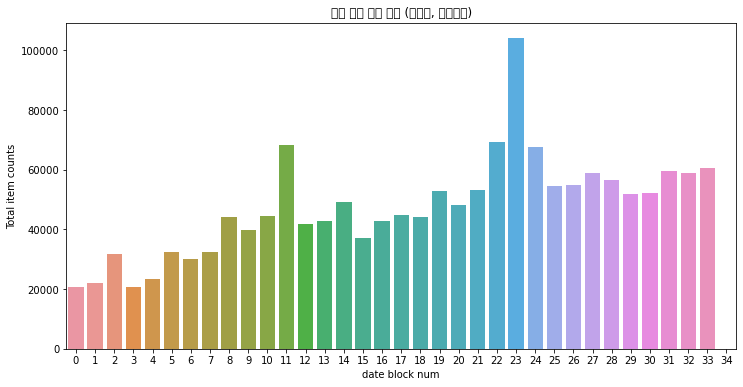

In [59]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot()

sns.barplot(x='date_block_num', y='item_cnt_sum', data=df_eda_month_sum)
ax.set(title='월별 판매 개수 총합 (전상점, 전아이템)', xlabel='date block num', ylabel='Total item counts')

plt.show()

C:\Users\yes47\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\yes47\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 52404 (\N{HANGUL SYLLABLE CE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\yes47\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\yes47\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 44036 (\N{HANGUL SYLLABLE GAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\yes47\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 46041 (\N{HANGUL SYLLABLE DONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\yes47\anaconda3\

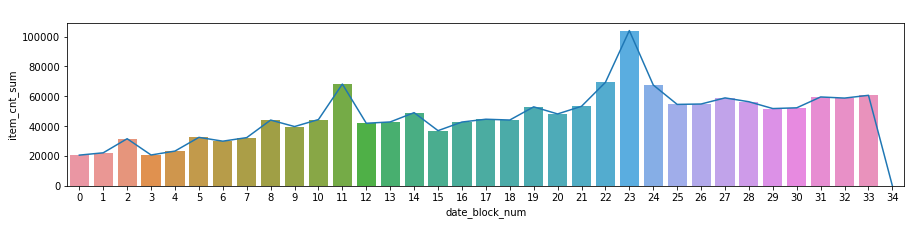

In [60]:
#희연 추가 - 꺾은선이 좀더 추세가 잘 보여서 추가로 넣었습니다 + 1년 주기 판매량 그래프와 통일성 
plt.figure(figsize = (15,3))
sns.lineplot(x="date_block_num", y="item_cnt_sum", data=df_eda_month_sum)
sns.barplot(x='date_block_num', y='item_cnt_sum', data=df_eda_month_sum)
plt.title('전체 기간 동안 월별 판매 개수 총합 (전상점, 전 아이템별)', color='white')
plt.show()

> 점점 판매량이 증가하는 형태 

<a id='step_yearly_cnt' href='#content_list'>목차로</a>
#### 1년 주기 동안의 판매량

In [61]:
df_tmp = df_basis_monthly.copy()

df_tmp['month'] = df_tmp['date_block_num'].apply(lambda x: (x % 12)+1)
df_tmp.head()

,date_block_num,shop_id,item_id,item_cnt,item_order,item_price_mean,city_id,shop_type_id,item_category_id,item_first,lv1_id,lv2_id,lv3_id,year,month
0,0,2,30,0.000,1,0.000,0,0,40,1,8,55,63,2013,1
1,0,2,31,0.000,1,0.000,0,0,37,1,8,53,59,2013,1
2,0,2,32,0.000,1,0.000,0,0,40,0,8,55,63,2013,1
3,0,2,33,1.000,1,499.000,0,0,37,0,8,53,59,2013,1
4,0,2,38,0.000,1,0.000,0,0,41,18,8,54,62,2013,1


In [62]:
df_eda_monthly_sum = df_tmp.groupby(['month']).agg({'item_cnt':'sum'})
df_eda_monthly_sum.head()

,item_cnt
month,
1,"130,143.000"
2,"119,603.000"
3,"135,525.000"
4,"116,656.000"
5,"122,483.000"


C:\Users\yes47\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 44033 (\N{HANGUL SYLLABLE GAG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\yes47\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 50900 (\N{HANGUL SYLLABLE WEOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\yes47\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\yes47\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 54032 (\N{HANGUL SYLLABLE PAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\yes47\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 47588 (\N{HANGUL SYLLABLE MAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\yes47\anacond

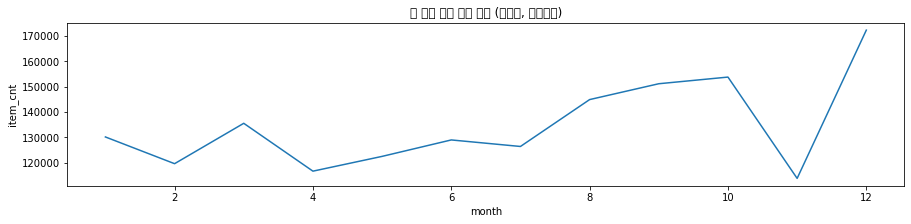

In [63]:
# 막대 그래프는 추세가 잘 보이지 않아 꺾은선 그래프로 넣었습니다 #희연추가
plt.figure(figsize = (15,3))
sns.lineplot(x="month", y="item_cnt", data=df_eda_monthly_sum )
plt.title('각 월별 판매 개수 총합 (전상점, 전아이템)')
plt.show()

> 연말로 갈 수록 판매량이 증가하는 형태 

<a id='step_city_cnt' href='#content_list'>목차로</a>
#### 도시별 판매량

In [64]:
df_basis_monthly.head()

,date_block_num,shop_id,item_id,item_cnt,item_order,item_price_mean,city_id,shop_type_id,item_category_id,item_first,lv1_id,lv2_id,lv3_id,year,month
0,0,2,30,0.000,1,0.000,0,0,40,1,8,55,63,2013,1
1,0,2,31,0.000,1,0.000,0,0,37,1,8,53,59,2013,1
2,0,2,32,0.000,1,0.000,0,0,40,0,8,55,63,2013,1
3,0,2,33,1.000,1,499.000,0,0,37,0,8,53,59,2013,1
4,0,2,38,0.000,1,0.000,0,0,41,18,8,54,62,2013,1


In [65]:
# (월, 도시 별) 총 판매량

# df_tmp = df_basis_city_cat.groupby(['date_block_num','city_id']).agg({'item_cnt_day':['sum']})
# df_tmp.columns = ['item_cnt_sum']
# df_tmp.reset_index(inplace = True)
# df_tmp.head()

df_tmp = df_basis_monthly.groupby(['date_block_num','city_id']).agg({'item_cnt':['sum']}).reset_index()
df_tmp.columns = ['date_block_num','city_id','item_cnt_sum']
df_tmp.head()

,date_block_num,city_id,item_cnt_sum
0,0,0,248.000
1,0,1,187.000
2,0,2,459.000
3,0,3,0.000
4,0,4,"1,422.000"


In [66]:
# 도시별 판매량의 월간 합계

df_eda_city_sum = df_tmp.groupby(['city_id']).agg({'item_cnt_sum':'sum'})
df_eda_city_sum.columns = ['item_cnt_sum']
df_eda_city_sum.reset_index(inplace = True)

df_eda_city_sum.head(10)


,city_id,item_cnt_sum
0,0,"19,033.000"
1,1,"16,838.000"
2,2,"24,268.000"
3,3,"24,640.000"
4,4,"89,014.000"
5,6,"13,429.000"
6,7,"44,374.000"
7,8,"26,251.000"
8,9,"38,539.000"
9,10,"32,649.000"


C:\Users\yes47\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\yes47\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\yes47\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\yes47\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 54032 (\N{HANGUL SYLLABLE PAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\yes47\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 47588 (\N{HANGUL SYLLABLE MAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\yes47\anaconda3\

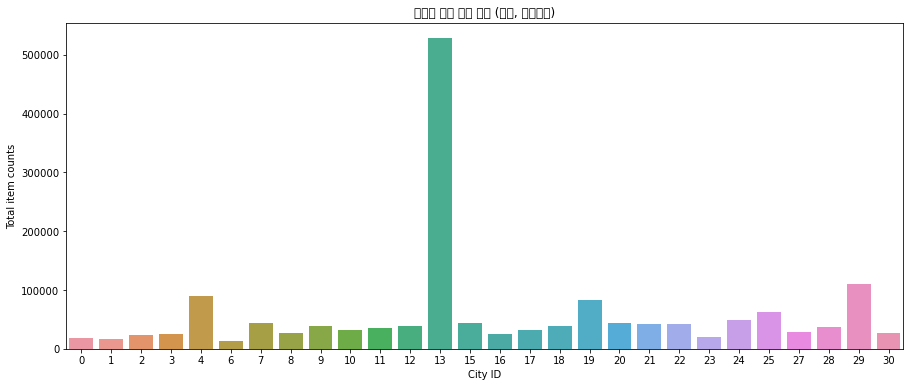

In [67]:
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot()

sns.barplot(x='city_id', y='item_cnt_sum', data=df_eda_city_sum)
ax.set(title='도시별 판매 개수 총합 (전월, 전아이템)', xlabel='City ID', ylabel='Total item counts')
plt.show()

In [68]:
df_shop.groupby(['city_id'])['city'].unique().to_frame()

,city
city_id,
0,[Адыгея]
1,[Балашиха]
2,[Волжский]
3,[Вологда]
4,[Воронеж]
5,[Выездная]
6,[Жуковский]
7,[Интернет]
8,[Казань]


- city_code 13 : Москва (모스크바) 가 독보적으로 판매량이 많음
- 모스크바가 러시아의 수도여서 인구수가 많아 판매량이 많은 것으로 추정

<a id='step_cat_lv1_cnt' href='#content_list'>목차로</a>
#### 카테고리별 판매량 - 대분류

In [69]:
df_basis_monthly.head()

,date_block_num,shop_id,item_id,item_cnt,item_order,item_price_mean,city_id,shop_type_id,item_category_id,item_first,lv1_id,lv2_id,lv3_id,year,month
0,0,2,30,0.000,1,0.000,0,0,40,1,8,55,63,2013,1
1,0,2,31,0.000,1,0.000,0,0,37,1,8,53,59,2013,1
2,0,2,32,0.000,1,0.000,0,0,40,0,8,55,63,2013,1
3,0,2,33,1.000,1,499.000,0,0,37,0,8,53,59,2013,1
4,0,2,38,0.000,1,0.000,0,0,41,18,8,54,62,2013,1


In [70]:
df_tmp = df_basis_monthly.groupby(['date_block_num','lv1_id']).agg({'item_cnt':['sum']})
df_tmp.columns = ['item_cnt_sum']
df_tmp.reset_index(inplace = True)
df_tmp.head()

,date_block_num,lv1_id,item_cnt_sum
0,0,0,812.000
1,0,1,671.000
2,0,3,598.000
3,0,4,145.000
4,0,5,0.000


In [71]:
df_eda_cat_sum = df_tmp.groupby(['lv1_id']).agg({'item_cnt_sum':sum})
df_eda_cat_sum.columns = ['item_cnt_sum']
df_eda_cat_sum.reset_index(inplace = True)
df_eda_cat_sum.head()

,lv1_id,item_cnt_sum
0,0,"46,443.000"
1,1,"10,341.000"
2,3,"39,363.000"
3,4,"15,876.000"
4,5,"11,911.000"


C:\Users\yes47\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 52852 (\N{HANGUL SYLLABLE KA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\yes47\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 53580 (\N{HANGUL SYLLABLE TE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\yes47\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\yes47\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 47532 (\N{HANGUL SYLLABLE RI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\yes47\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\yes47\anaconda3\li

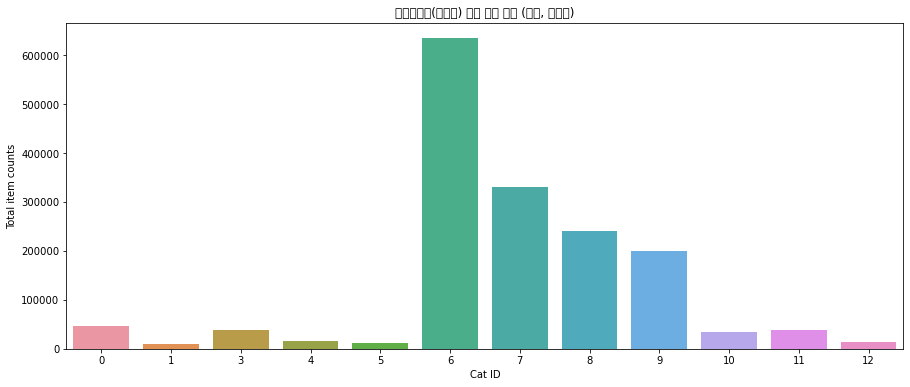

In [72]:
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot()

sns.barplot(x='lv1_id', y='item_cnt_sum', data=df_eda_cat_sum)
ax.set(title='카테고리별(대분류) 판매 개수 총합 (전월, 전상점)',
       xlabel='Cat ID', ylabel='Total item counts'
      )
plt.show()

In [73]:
df_cat.groupby(['lv1_id'])['lv1'].unique().to_frame()

,lv1
lv1_id,
0,[Accessories]
1,[Batteries]
2,[Blank media]
3,[Books]
4,[Delivery of goods]
5,[Game consoles]
6,[Games]
7,[Gift]
8,[Movie]


- lv1 (카테고리 대분류) 6번 Games
- 7번 Gift, 8번 Movie, 9번 Music 순으로 많이 팔렸다

<a id='step_cat_lv2_cnt' href='#content_list'>목차로</a>
#### 카테고리별 판매량 - 중분류
- 카테고리 세부분류별 판매량

In [74]:
df_basis_monthly.head()

,date_block_num,shop_id,item_id,item_cnt,item_order,item_price_mean,city_id,shop_type_id,item_category_id,item_first,lv1_id,lv2_id,lv3_id,year,month
0,0,2,30,0.000,1,0.000,0,0,40,1,8,55,63,2013,1
1,0,2,31,0.000,1,0.000,0,0,37,1,8,53,59,2013,1
2,0,2,32,0.000,1,0.000,0,0,40,0,8,55,63,2013,1
3,0,2,33,1.000,1,499.000,0,0,37,0,8,53,59,2013,1
4,0,2,38,0.000,1,0.000,0,0,41,18,8,54,62,2013,1


In [75]:
df_tmp = df_basis_monthly.groupby(['date_block_num','lv2_id']).agg({'item_cnt':['sum']})
df_tmp.columns = ['item_cnt_sum']
df_tmp.reset_index(inplace = True)
df_tmp.head()

,date_block_num,lv2_id,item_cnt_sum
0,0,0,0.000
1,0,2,293.000
2,0,3,0.000
3,0,5,90.000
4,0,6,429.000


In [76]:
df_eda_subtype_sum = df_tmp.groupby(['lv2_id']).agg({'item_cnt_sum':sum})
df_eda_subtype_sum.columns = ['item_cnt_sum']
df_eda_subtype_sum.reset_index(inplace = True)

df_eda_subtype_sum.head()

,lv2_id,item_cnt_sum
0,0,0.000
1,2,"6,916.000"
2,3,"19,328.000"
3,5,"2,105.000"
4,6,"13,520.000"


C:\Users\yes47\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 52852 (\N{HANGUL SYLLABLE KA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\yes47\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 53580 (\N{HANGUL SYLLABLE TE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\yes47\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\yes47\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 47532 (\N{HANGUL SYLLABLE RI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\yes47\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\yes47\anaconda3\li

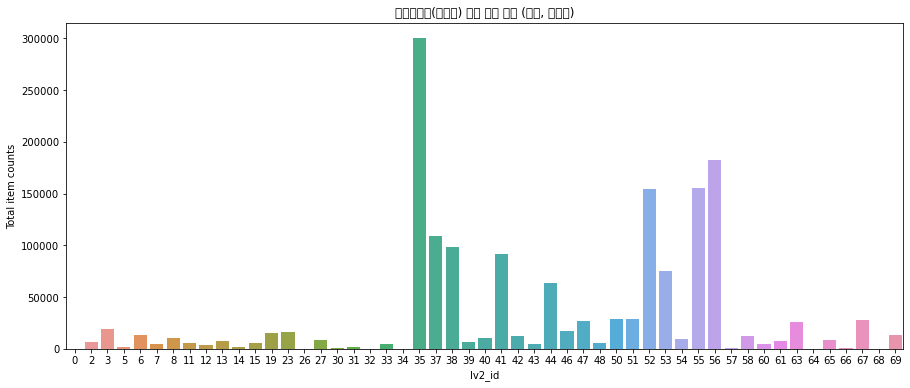

In [77]:
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot()

sns.barplot(x='lv2_id', y='item_cnt_sum', data=df_eda_subtype_sum)
ax.set(title='카테고리별(소분류) 판매 개수 총합 (전월, 전상점)',
       xlabel='lv2_id', ylabel='Total item counts'
      )

plt.show()

In [78]:
df_cat.groupby(['lv2_id'])['lv2'].unique().to_frame()

,lv2
lv2_id,
0,[Accessories - PC Headsets/Headphones]
1,[Accessories - PS2]
2,[Accessories - PS3]
3,[Accessories - PS4]
4,[Accessories - PSP]
5,[Accessories - PSVita]
6,[Accessories - XBOX 360]
7,[Accessories - XBOX ONE]
8,[Batteries - (-3)]


- lv2_id (카테고리 중분류)
- 35 Games - PC, 56 Music - CD, 55 Movie - DVD, 52 Gift - bags, Albums, mouse pads
- 순으로 많이 팔렸다

<a id='step_corr' href='#content_list'>목차로</a>
#### 상관관계 분석

In [79]:
df_basis_monthly.head()

,date_block_num,shop_id,item_id,item_cnt,item_order,item_price_mean,city_id,shop_type_id,item_category_id,item_first,lv1_id,lv2_id,lv3_id,year,month
0,0,2,30,0.000,1,0.000,0,0,40,1,8,55,63,2013,1
1,0,2,31,0.000,1,0.000,0,0,37,1,8,53,59,2013,1
2,0,2,32,0.000,1,0.000,0,0,40,0,8,55,63,2013,1
3,0,2,33,1.000,1,499.000,0,0,37,0,8,53,59,2013,1
4,0,2,38,0.000,1,0.000,0,0,41,18,8,54,62,2013,1


In [80]:
df_tmp = df_basis_monthly[df_basis_monthly['item_price_mean'].notnull()]
df_tmp.head()

,date_block_num,shop_id,item_id,item_cnt,item_order,item_price_mean,city_id,shop_type_id,item_category_id,item_first,lv1_id,lv2_id,lv3_id,year,month
0,0,2,30,0.000,1,0.000,0,0,40,1,8,55,63,2013,1
1,0,2,31,0.000,1,0.000,0,0,37,1,8,53,59,2013,1
2,0,2,32,0.000,1,0.000,0,0,40,0,8,55,63,2013,1
3,0,2,33,1.000,1,499.000,0,0,37,0,8,53,59,2013,1
4,0,2,38,0.000,1,0.000,0,0,41,18,8,54,62,2013,1


In [81]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7497000 entries, 0 to 7496999
Data columns (total 15 columns):
 #   Column            Dtype  
---  ------            -----  
 0   date_block_num    int8   
 1   shop_id           int8   
 2   item_id           int16  
 3   item_cnt          float32
 4   item_order        int8   
 5   item_price_mean   float32
 6   city_id           int8   
 7   shop_type_id      int8   
 8   item_category_id  int8   
 9   item_first        int8   
 10  lv1_id            int8   
 11  lv2_id            int8   
 12  lv3_id            int8   
 13  year              int16  
 14  month             int8   
dtypes: float32(2), int16(2), int8(11)
memory usage: 221.6 MB


In [82]:
# # 시간이 오래 걸린다.. 필요하지 않을땐 주석 해두자
# j1 = sns.jointplot(x='date_block_num', y='item_price_mean', kind='reg', data = df_tmp)
# j1.fig.suptitle('기간별 가격추이')

# plt.show()

# 하단 이미지 참조

# 시간이 지날 수록 비싼 가격의 판매량이 늘어난다

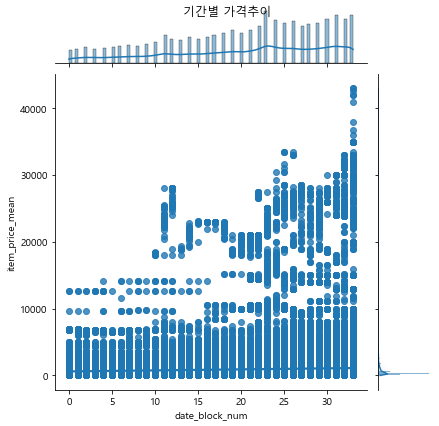

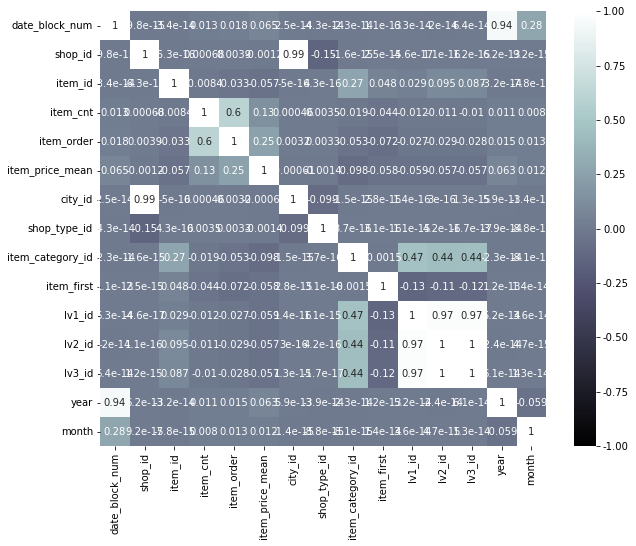

In [83]:
plt.figure(figsize=(10,8))
sns.heatmap(df_basis_monthly.corr(), vmin=-1, vmax=1, annot=True, cmap="bone")
plt.show()

<a id='step_4' href='#content_list'>목차로</a>
## 4. 피처 엔지니어링

<a id='step_new_item' href='#content_list'>목차로</a>
### 신상 여부

In [84]:
df_basis_monthly.rename(columns = {'item_cnt':'item_cnt_month'}, inplace=True)

In [85]:
df_basis_monthly.head().T

,0,1,2,3,4
date_block_num,0.000,0.000,0.000,0.000,0.000
shop_id,2.000,2.000,2.000,2.000,2.000
item_id,30.000,31.000,32.000,33.000,38.000
item_cnt_month,0.000,0.000,0.000,1.000,0.000
item_order,1.000,1.000,1.000,1.000,1.000
item_price_mean,0.000,0.000,0.000,499.000,0.000
city_id,0.000,0.000,0.000,0.000,0.000
shop_type_id,0.000,0.000,0.000,0.000,0.000
item_category_id,40.000,37.000,40.000,37.000,41.000
item_first,1.000,1.000,0.000,0.000,18.000


In [86]:
# 첫 판매월이 현재 월과 같다면 신상품
# 신상품이라면 True, 아니면 False!
df_basis_monthly['new_item'] = df_basis_monthly['item_first'] == df_basis_monthly['date_block_num']

In [87]:
# 레이블 인코딩 True, False
list_tmp = list(df_basis_monthly['new_item'].values)
le.fit(list_tmp)
df_basis_monthly['new_item'] = le.transform(list_tmp)

In [88]:
df_basis_monthly.head().T

,0,1,2,3,4
date_block_num,0.000,0.000,0.000,0.000,0.000
shop_id,2.000,2.000,2.000,2.000,2.000
item_id,30.000,31.000,32.000,33.000,38.000
item_cnt_month,0.000,0.000,0.000,1.000,0.000
item_order,1.000,1.000,1.000,1.000,1.000
item_price_mean,0.000,0.000,0.000,499.000,0.000
city_id,0.000,0.000,0.000,0.000,0.000
shop_type_id,0.000,0.000,0.000,0.000,0.000
item_category_id,40.000,37.000,40.000,37.000,41.000
item_first,1.000,1.000,0.000,0.000,18.000


### 첫 판매 후 경과 기간

In [89]:
# 현재 월 - 첫 판매월 = 첫 판매 이후 기간이 얼마나 지났는지
df_basis_monthly['item_first_after'] = df_basis_monthly['date_block_num'] - df_basis_monthly['item_first']

In [90]:
df_basis_monthly.head().T

,0,1,2,3,4
date_block_num,0.000,0.000,0.000,0.000,0.000
shop_id,2.000,2.000,2.000,2.000,2.000
item_id,30.000,31.000,32.000,33.000,38.000
item_cnt_month,0.000,0.000,0.000,1.000,0.000
item_order,1.000,1.000,1.000,1.000,1.000
item_price_mean,0.000,0.000,0.000,499.000,0.000
city_id,0.000,0.000,0.000,0.000,0.000
shop_type_id,0.000,0.000,0.000,0.000,0.000
item_category_id,40.000,37.000,40.000,37.000,41.000
item_first,1.000,1.000,0.000,0.000,18.000


### rolling

이동평균 구하기
- 주기적인 움직임을 있을 때는 해당 주기에 따라 이동평균을 구하면 그 영향을 없앨 수 있음

```
rolling(window, min_periods = None, freq = None, center = False, win_type = None,
                            on = None,  axis = 0, closed = None)
```
- 일정한 범위에서 규칙적으로 연산을 해줘야 하는 경우가 존재

In [91]:
# Min value
f_min = lambda x: x.rolling(window=3, min_periods=1).min() #min_periods=1, 존재하지 않는 행을 참조해야할 땐 최소 1개의 행만을 참조하여 결과를 반환
# Max value
f_max = lambda x: x.rolling(window=3, min_periods=1).max()
# Mean value
f_mean = lambda x: x.rolling(window=3, min_periods=1).mean() #3달 기준 이동 평균 구하기 
# Std value
f_std = lambda x: x.rolling(window=3, min_periods=1).std()

function_list = [f_min, f_max, f_mean,f_std]
function_name = ['min', 'max', 'mean','std']

In [92]:
for i in range(len(function_list)):
    df_basis_monthly[('item_cnt_d_%s' % function_name[i])]\
    = df_basis_monthly.groupby(['date_block_num'])['item_cnt_month'].apply(function_list[i])

In [93]:
for i in range(len(function_list)):
    df_basis_monthly[('item_cnt_di_%s' % function_name[i])]\
    = df_basis_monthly.groupby(['date_block_num','item_id'])['item_cnt_month'].apply(function_list[i])

In [94]:
for i in range(len(function_list)): 
    df_basis_monthly[('item_cnt_ds_%s' % function_name[i])]\
    = df_basis_monthly.groupby(['date_block_num','shop_id'])['item_cnt_month'].apply(function_list[i])

In [95]:
# for i in range(len(function_list)):
#     df_basis_monthly[('item_cnt_ds_%s' % function_name[i])]\
#     = df_basis_monthly.groupby(['date_block_num','shop_id','item_id'])['item_cnt_month'].apply(function_list[i])

In [96]:
def lag_feature(df, idx_features, col_list):
    # 시차 피처 생성에 필요한 DataFrame 부분만 복사
    
    for col in col_list:
        
        shifted = df[idx_features + [col]].copy()
        
        # 시차 피처명
        lag_feature_name = col+'_lag' #+str(i)
        
        # shifted 열 이름 설정
        shifted.columns = idx_features + [lag_feature_name]
        
        # shift(i)
        shifted['date_block_num'] += 1
        
        # idx_feature를 기준으로 df와 shifted 병합
        df = df.merge(shifted.drop_duplicates(), on=idx_features)
#         print(lag_feature_name)
        # 결측값 0으로 대체
        df[lag_feature_name] = df[lag_feature_name].fillna(0)
        
    return df

In [97]:
idx_features = ['date_block_num','shop_id','item_id']
col_list = [#'item_cnt_min', 'item_cnt_max', 'item_cnt_mean',
            'item_cnt_d_min', 'item_cnt_d_max', 'item_cnt_d_mean', 
            'item_cnt_d_std','item_cnt_di_min', 'item_cnt_di_max', 
            'item_cnt_di_mean','item_cnt_di_std', 'item_cnt_ds_min', 
            'item_cnt_ds_max','item_cnt_ds_mean', 'item_cnt_ds_std'
           ]

# idx_features를 기준으로 월간 판매량의 세 달치 시차 피처 생성
df_basis_monthly = lag_feature(df_basis_monthly,
                               idx_features = idx_features,
                               col_list = col_list
                              )
                        

In [98]:
df_basis_monthly.fillna(0, inplace=True)
df_basis_monthly.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_order,item_price_mean,city_id,shop_type_id,item_category_id,item_first,lv1_id,lv2_id,lv3_id,year,month,new_item,item_first_after,item_cnt_d_min,item_cnt_d_max,item_cnt_d_mean,item_cnt_d_std,item_cnt_di_min,item_cnt_di_max,item_cnt_di_mean,item_cnt_di_std,item_cnt_ds_min,item_cnt_ds_max,item_cnt_ds_mean,item_cnt_ds_std,item_cnt_d_min_lag,item_cnt_d_max_lag,item_cnt_d_mean_lag,item_cnt_d_std_lag,item_cnt_di_min_lag,item_cnt_di_max_lag,item_cnt_di_mean_lag,item_cnt_di_std_lag,item_cnt_ds_min_lag,item_cnt_ds_max_lag,item_cnt_ds_mean_lag,item_cnt_ds_std_lag
0,12,2,30,0.000,1,0.000,0,0,40,1,8,55,63,2014,1,0,11,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,12,2,31,0.000,1,0.000,0,0,37,1,8,53,59,2014,1,0,11,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,12,2,32,1.000,1,119.000,0,0,40,0,8,55,63,2014,1,0,12,0.000,1.000,0.333,0.577,1.000,1.000,1.000,0.000,0.000,1.000,0.333,0.577,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,12,2,33,1.000,1,199.000,0,0,37,0,8,53,59,2014,1,0,12,0.000,1.000,0.667,0.577,1.000,1.000,1.000,0.000,0.000,1.000,0.667,0.577,0.000,1.000,0.333,0.577,1.000,1.000,1.000,0.000,0.000,1.000,0.333,0.577
4,12,2,38,0.000,1,0.000,0,0,41,18,8,54,62,2014,1,0,-6,0.000,1.000,0.667,0.577,0.000,0.000,0.000,0.000,0.000,1.000,0.667,0.577,0.000,1.000,0.333,0.577,0.000,0.000,0.000,0.000,0.000,1.000,0.333,0.577


### lag 변수 # 주영님 것 추가 

In [99]:
df_basis_monthly=reduce_mem_usage(df_basis_monthly)

Memory usage of dataframe is 1090.02 MB --> 606.09 MB (Decreased by 44.4%)


In [100]:
df_basis_monthly.head().T

,0,1,2,3,4
date_block_num,12.000,12.000,12.000,12.000,12.000
shop_id,2.000,2.000,2.000,2.000,2.000
item_id,30.000,31.000,32.000,33.000,38.000
item_cnt_month,0.000,0.000,1.000,1.000,0.000
item_order,1.000,1.000,1.000,1.000,1.000
item_price_mean,0.000,0.000,119.000,199.000,0.000
city_id,0.000,0.000,0.000,0.000,0.000
shop_type_id,0.000,0.000,0.000,0.000,0.000
item_category_id,40.000,37.000,40.000,37.000,41.000
item_first,1.000,1.000,0.000,0.000,18.000


In [101]:
def add_mean_feature(df, mean_features, idx_features):
    # 기준 피처 확인
    assert (idx_features[0] == 'date_block_num') and len(idx_features) in [2,3]
    # (기준 피처의 첫번째가 'date_block_num'이고 기준 피처 개수가 2개 혹은 3개인지 확인)
    # (꼭 첫번째가 'date_block_num'이여야 함!!)
    
    # 파생 피처명 설정
    if len(idx_features) == 2:
        feature_name = idx_features[1].split('_')[0] + '_avg_item_cnt'
    else:
        feature_name = idx_features[1].split('_')[0] + '_' +\
        idx_features[2].split('_')[0] + '_avg_item_cnt'
    # (기준 피처 개수에 따라 feature_name 형성)
    
    # 기준 피처를 토대로 그룹화해 월간 평균 판매량 구하기
    df_temp = df.groupby(idx_features).agg({'item_cnt_month':'mean'})
    df_temp = df_temp.reset_index()
    df_temp = df_temp.rename(columns={'item_cnt_month':feature_name})
#     df_temp.columns = feature_name
    # (df(df_basis_monthly)에 idx_feature 기준으로 'item_cnt_month'을 'mean'해서 병합)
    # (column명 feature_name으로 재설정)
    # df와 group 병합
    df = df.merge(df_temp, on=idx_features, how='left')
    # (df(df_basis_monthly)에 merge)
    
    # 새로 만든 feature_name 피처명을 mean_feature 리스트에 추가
    mean_features.append(feature_name)
    
    return df, mean_features

In [102]:
# 그룹화 기준 피처 중 'item_id'가 포함된 파생 피처명을 담을 리스트
item_mean_features = []

# ['date_block_num','item_id'] 그룹화한 월간 평균 판매량 파생 피처 생성
# 상품ID별 평균 판매량
df_basis_monthly, item_mean_features = add_mean_feature(df=df_basis_monthly,
                                                  mean_features=item_mean_features,
                                                  idx_features=['date_block_num','item_id'])

# ['date_block_num','item_id','city_id'] 그룹화한 월간 평균 판매량 파생 피처 생성
# 상품ID별 도시별 평균 판매량
df_basis_monthly, item_mean_features = add_mean_feature(df=df_basis_monthly,
                                mean_features=item_mean_features,
                                idx_features=['date_block_num','item_id','city_id'])

# ['date_block_num','item_id','shop_type_id'] 그룹화한 월간 평균 판매량 파생 피처 생성
# 상품ID별 shop type별(mall type??) 평균 판매량
df_basis_monthly, item_mean_features = add_mean_feature(df=df_basis_monthly,
                                mean_features=item_mean_features,
                                idx_features=['date_block_num','item_id','shop_type_id'])

In [103]:
# 그룹화 기준 피처 중 'shop_id'가 포함된 파생 피처명을 담을 리스트
shop_mean_features = []

# ['date_block_num','shop_id','lv1_id'] 그룹화한 월간 평균 판매량 파생 피처 생성
# 상품ID별 평균 판매량
df_basis_monthly, item_mean_features = add_mean_feature(df=df_basis_monthly,
                                mean_features=item_mean_features,
                                idx_features=['date_block_num','shop_id','lv1_id'])

In [104]:
df_basis_monthly.head().T

,0,1,2,3,4
date_block_num,12.000,12.000,12.000,12.000,12.000
shop_id,2.000,2.000,2.000,2.000,2.000
item_id,30.000,31.000,32.000,33.000,38.000
item_cnt_month,0.000,0.000,1.000,1.000,0.000
item_order,1.000,1.000,1.000,1.000,1.000
item_price_mean,0.000,0.000,119.000,199.000,0.000
city_id,0.000,0.000,0.000,0.000,0.000
shop_type_id,0.000,0.000,0.000,0.000,0.000
item_category_id,40.000,37.000,40.000,37.000,41.000
item_first,1.000,1.000,0.000,0.000,18.000


lag feature

In [105]:
def lag_features(df, idx_features, col, lags=3):
    '''
    이전 달의 feature들을 현재 월의 feature로 shift
    이 때, 이전 달의 정보는 lags에,
    사용할 feature 들은 col에 넣음
    '''
    # 시차 피처 생성에 필요한 DataFrame 부분만 복사
    shifted = df[idx_features + [col]].copy()
    
    # 시차 피처 생성
    for i in range(1, lags+1):
        # 시차 피처명
        lag_feature_name = col+'_lag_'+str(i)
        # shifted 열 이름 설정
        shifted.columns = idx_features + [lag_feature_name]
        # shift(i)
        shifted['date_block_num'] += i
        # idx_feature를 기준으로 df와 shifted 병합
        df = df.merge(shifted.drop_duplicates(), on=idx_features, how='left')
        # 결측값 0으로 대체
        df[lag_feature_name] = df[lag_feature_name].fillna(0)
    
    return df

In [106]:
# item_cnt_month_sum_lag : item_cnt_month_sum(월별 판매량)의 시차 1,2,3월

idx_features = ['date_block_num','shop_id','item_id']

# idx_features를 기준으로 월간 판매량의 세 달치 시차 피처 생성
df_basis_monthly= lag_features(df=df_basis_monthly,
                        idx_features=idx_features,
                        col='item_cnt_month',
                        lags=3)

In [107]:
# item_price_month_mean_lag : item_price_month_mean_lag(월별 평균 판매가)의 시차 1,2,3월

idx_features = ['date_block_num','shop_id','item_id']

# idx_features를 기준으로 월간 판매량의 세 달치 시차 피처 생성
df_basis_monthly = lag_features(df=df_basis_monthly,
                            idx_features=idx_features,
                            col='item_price_mean',
                            lags=3)

In [108]:
# idx_feature 기준으로 item_mean_features 요소별 시차 피처 생성
for i in item_mean_features:
    df_basis_monthly = lag_features(df=df_basis_monthly,
                             idx_features=idx_features,
                             col=i,
                             lags=3)

# item_mean_features 피처 제거
# df_basis_monthly = df_basis_monthly.drop(item_mean_features, axis=1)
# (시차 피처 만들기 위한 변수여서 제거 해줬습니다)

In [109]:
# idx_feature 기준으로 shop_mean_features 요소별 시차 피처 생성
for i in shop_mean_features:
    df_basis_monthly = lag_features(df=df_basis_monthly,
                             idx_features=idx_features,
                             col=i,
                             lags=3)

# item_mean_features 피처 제거
# df_basis_monthly = df_basis_monthly.drop(shop_mean_features, axis=1)
# (시차 피처 만들기 위한 변수여서 제거 해줬습니다)

In [110]:
df_basis_monthly['item_cnt_month_move_mean_1'] = df_basis_monthly['item_cnt_month_lag_1'].rolling(window=3, min_periods=1).mean()
df_basis_monthly['item_cnt_month_move_mean_2'] = df_basis_monthly['item_cnt_month_lag_2'].rolling(window=3, min_periods=1).mean()
df_basis_monthly['item_cnt_month_move_mean_3'] = df_basis_monthly['item_cnt_month_lag_3'].rolling(window=3, min_periods=1).mean()


In [111]:
df_basis_monthly['item_price_mean_move_mean_1'] = df_basis_monthly['item_price_mean_lag_1'].rolling(window=3, min_periods=1).mean()
df_basis_monthly['item_price_mean_move_mean_2'] = df_basis_monthly['item_price_mean_lag_2'].rolling(window=3, min_periods=1).mean()
df_basis_monthly['item_price_mean_move_mean_3'] = df_basis_monthly['item_price_mean_lag_3'].rolling(window=3, min_periods=1).mean()


In [112]:
df_basis_monthly['item_cnt_month_lag_mean'] = df_basis_monthly[['item_cnt_month_lag_1',
                                                   'item_cnt_month_lag_2',
                                                   'item_cnt_month_lag_3']].mean()

In [113]:
# 시차로 세달 치를 만들었기 때문에 월ID 3미만 데이터를 제거해야 함
df_basis_monthly = df_basis_monthly.drop(df_basis_monthly[df_basis_monthly['date_block_num']<3].index)

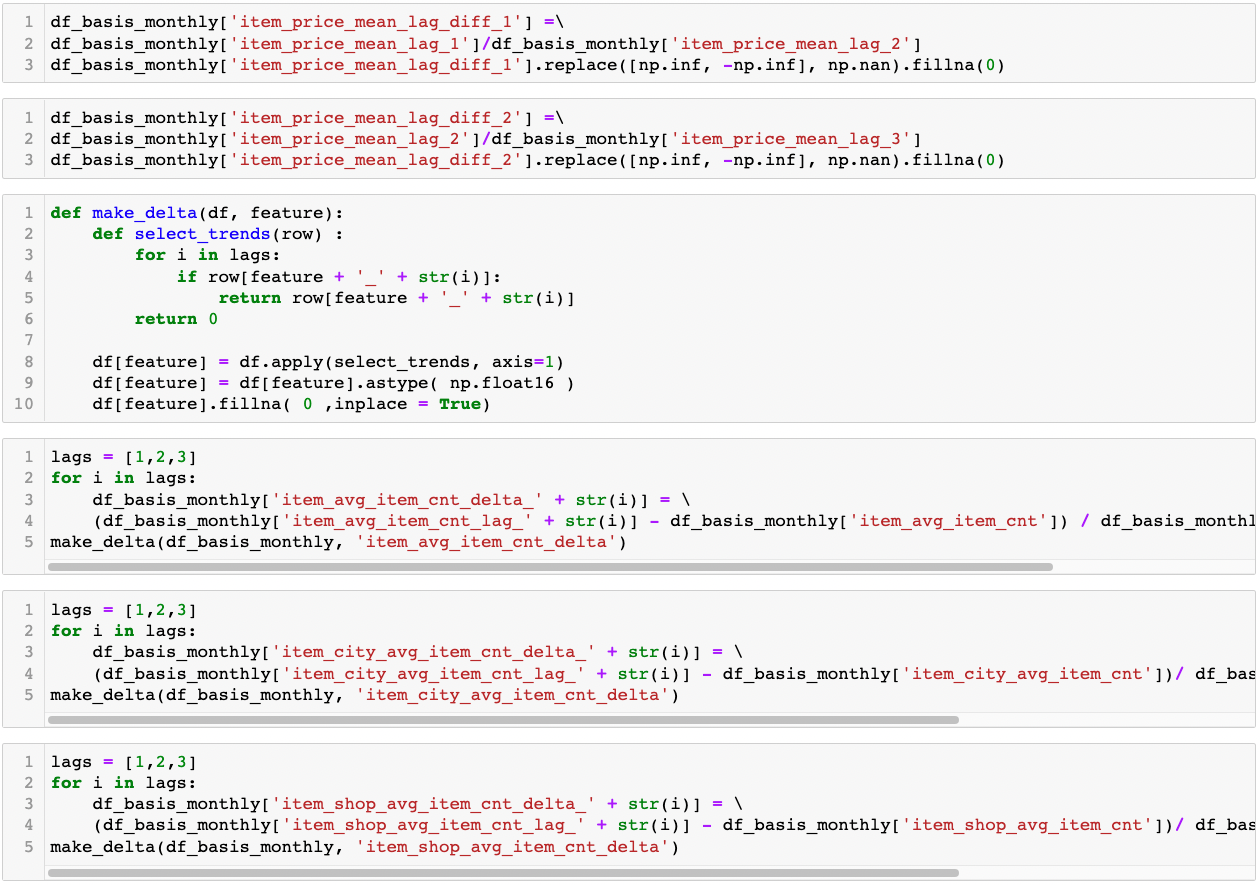

<a id='step_5' href='#content_list'>목차로</a>
## 5. 모델링

<a id='step_5_1' href='#content_list'>목차로</a>
### 5-1 train, validation, test set으로 구분 짓기

In [114]:
df_basis_monthly_enc=df_basis_monthly.copy()

In [115]:
df_basis_monthly.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'item_order',
       'item_price_mean', 'city_id', 'shop_type_id', 'item_category_id',
       'item_first', 'lv1_id', 'lv2_id', 'lv3_id', 'year', 'month', 'new_item',
       'item_first_after', 'item_cnt_d_min', 'item_cnt_d_max',
       'item_cnt_d_mean', 'item_cnt_d_std', 'item_cnt_di_min',
       'item_cnt_di_max', 'item_cnt_di_mean', 'item_cnt_di_std',
       'item_cnt_ds_min', 'item_cnt_ds_max', 'item_cnt_ds_mean',
       'item_cnt_ds_std', 'item_cnt_d_min_lag', 'item_cnt_d_max_lag',
       'item_cnt_d_mean_lag', 'item_cnt_d_std_lag', 'item_cnt_di_min_lag',
       'item_cnt_di_max_lag', 'item_cnt_di_mean_lag', 'item_cnt_di_std_lag',
       'item_cnt_ds_min_lag', 'item_cnt_ds_max_lag', 'item_cnt_ds_mean_lag',
       'item_cnt_ds_std_lag', 'item_avg_item_cnt', 'item_city_avg_item_cnt',
       'item_shop_avg_item_cnt', 'shop_lv1_avg_item_cnt',
       'item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3',

In [116]:
# 바이너리 인코딩 ON_OFF
_enc_TF = 0
# _enc_TF=1

In [117]:
if _enc_TF ==1: # 바이너리 인코딩 on
    df_basis_monthly_enc['year'].replace({2013:1,2014:2,2015:3},inplace=True) #숫자가 너무 크기 때문에 숫자크기 줄여줌 

    #Import the libraries
    import category_encoders as ce

    #Create object for binary encoding  # 바이너리 인코딩 #숫자형이지만 카테고리인 feature 넣어주기
    encoder= ce.BinaryEncoder(cols=['year','month','shop_id', 'item_id', 'item_category_id'],return_df=True) 

    #Fit and Transform Data    
    df_basis_monthly_enc=encoder.fit_transform(df_basis_monthly_enc) 

In [118]:
if _enc_TF ==0:
    df_basis_monthly = reduce_mem_usage(df_basis_monthly)
if _enc_TF ==1:
    df_basis_monthly_enc = reduce_mem_usage(df_basis_monthly_enc)

Memory usage of dataframe is 1263.86 MB --> 1169.89 MB (Decreased by 7.4%)


train,test,validation
- 0~32개월까지는 train data
- 33개월은 validation data
- 34개월은 test data

In [119]:
# df_basis_monthly
if _enc_TF ==0:
    train_set = df_basis_monthly[df_basis_monthly.date_block_num < 33].copy()
    validation_set = df_basis_monthly[df_basis_monthly.date_block_num == 33].copy()
    test_set = df_basis_monthly[df_basis_monthly.date_block_num == 34].copy()
    
# df_basis_monthly_enc
if _enc_TF ==1:
    train_set = df_basis_monthly_enc[df_basis_monthly_enc.date_block_num < 33].copy()
    validation_set = df_basis_monthly_enc[df_basis_monthly_enc.date_block_num == 33].copy()
    test_set = df_basis_monthly_enc[df_basis_monthly_enc.date_block_num == 34].copy()

In [120]:
# df_basis_monthly
if _enc_TF ==0:
    print('Train set records:', train_set.shape[0])
    print('Validation set records:', validation_set.shape[0])
    print('Test set records:', test_set.shape[0])

    print('Train set records: %s (%.f%% of complete data)' % (train_set.shape[0], ((train_set.shape[0]/df_basis_monthly.shape[0])*100)))
    print('Validation set records: %s (%.f%% of complete data)' % (validation_set.shape[0], ((validation_set.shape[0]/df_basis_monthly.shape[0])*100)))
    
# df_basis_monthly_enc
if _enc_TF ==1:
    print('Train set records:', train_set.shape[0])
    print('Validation set records:', validation_set.shape[0])
    print('Test set records:', test_set.shape[0])

    print('Train set records: %s (%.f%% of complete data)' % (train_set.shape[0], ((train_set.shape[0]/df_basis_monthly_enc.shape[0])*100)))
    print('Validation set records: %s (%.f%% of complete data)' % (validation_set.shape[0], ((validation_set.shape[0]/df_basis_monthly_enc.shape[0])*100)))

Train set records: 4498200
Validation set records: 214200
Test set records: 214200
Train set records: 4498200 (91% of complete data)
Validation set records: 214200 (4% of complete data)


In [121]:
### 최종 분리!!
# 훈련데이터 (피처)
X_train = train_set.drop(['item_cnt_month'], axis=1)
# 훈련데이터 (타깃값)
y_train = train_set['item_cnt_month']  # 독립변수 Y
y_train = y_train.clip(0,20)  # 타깃값을 0~20으로 제한

# 검증 데이터 (피처)
X_valid = validation_set.drop(['item_cnt_month'], axis=1)  # 검증용 
# 검증 데이터 (타깃값)
y_valid = validation_set['item_cnt_month']
y_valid = y_valid.clip(0,20)  # 타깃값을 0~20으로 제한

# 테스트 데이터(피처)
X_test = test_set.drop(['item_cnt_month'], axis=1)

----------------------------------

## 모델링

<a id='step_linear_km' href='#content_list'>목차로</a>
### Linear Regression

In [122]:
list(df_basis_monthly_enc.columns)

['date_block_num',
 'shop_id',
 'item_id',
 'item_cnt_month',
 'item_order',
 'item_price_mean',
 'city_id',
 'shop_type_id',
 'item_category_id',
 'item_first',
 'lv1_id',
 'lv2_id',
 'lv3_id',
 'year',
 'month',
 'new_item',
 'item_first_after',
 'item_cnt_d_min',
 'item_cnt_d_max',
 'item_cnt_d_mean',
 'item_cnt_d_std',
 'item_cnt_di_min',
 'item_cnt_di_max',
 'item_cnt_di_mean',
 'item_cnt_di_std',
 'item_cnt_ds_min',
 'item_cnt_ds_max',
 'item_cnt_ds_mean',
 'item_cnt_ds_std',
 'item_cnt_d_min_lag',
 'item_cnt_d_max_lag',
 'item_cnt_d_mean_lag',
 'item_cnt_d_std_lag',
 'item_cnt_di_min_lag',
 'item_cnt_di_max_lag',
 'item_cnt_di_mean_lag',
 'item_cnt_di_std_lag',
 'item_cnt_ds_min_lag',
 'item_cnt_ds_max_lag',
 'item_cnt_ds_mean_lag',
 'item_cnt_ds_std_lag',
 'item_avg_item_cnt',
 'item_city_avg_item_cnt',
 'item_shop_avg_item_cnt',
 'shop_lv1_avg_item_cnt',
 'item_cnt_month_lag_1',
 'item_cnt_month_lag_2',
 'item_cnt_month_lag_3',
 'item_price_mean_lag_1',
 'item_price_mean_lag_2

In [123]:
# Use only part of features on linear Regression.
lm_features = ['date_block_num',
 'shop_id',
 'item_id',
#  'item_cnt_month',
 'item_order',
 'item_price_mean',
 'city_id',
 'shop_type_id',
 'item_category_id',
 'item_first',
 'lv1_id',
 'lv2_id',
 'lv3_id',
 'year',
 'month',
 'new_item',
 'item_first_after']
#  'item_cnt_d_min',
#  'item_cnt_d_max',
#  'item_cnt_d_mean',
#  'item_cnt_d_std',
#  'item_cnt_di_min',
#  'item_cnt_di_max',
#  'item_cnt_di_mean',
#  'item_cnt_di_std',
#  'item_cnt_ds_min',
#  'item_cnt_ds_max',
#  'item_cnt_ds_mean',
#  'item_cnt_ds_std',
#  'item_cnt_d_min_lag',
#  'item_cnt_d_max_lag',
#  'item_cnt_d_mean_lag',
#  'item_cnt_d_std_lag',
#  'item_cnt_di_min_lag',
#  'item_cnt_di_max_lag',
#  'item_cnt_di_mean_lag',
#  'item_cnt_di_std_lag',
#  'item_cnt_ds_min_lag',
#  'item_cnt_ds_max_lag',
#  'item_cnt_ds_mean_lag',
#  'item_cnt_ds_std_lag',
#  'item_avg_item_cnt',
#  'item_city_avg_item_cnt',
#  'item_shop_avg_item_cnt',
#  'shop_lv1_avg_item_cnt',
#  'item_cnt_month_lag_1',
#  'item_cnt_month_lag_2',
#  'item_cnt_month_lag_3',
#  'item_price_mean_lag_1',
#  'item_price_mean_lag_2',
#  'item_price_mean_lag_3',
#  'item_avg_item_cnt_lag_1',
#  'item_avg_item_cnt_lag_2',
#  'item_avg_item_cnt_lag_3',
#  'item_city_avg_item_cnt_lag_1',
#  'item_city_avg_item_cnt_lag_2',
#  'item_city_avg_item_cnt_lag_3',
#  'item_shop_avg_item_cnt_lag_1',
#  'item_shop_avg_item_cnt_lag_2',
#  'item_shop_avg_item_cnt_lag_3',
#  'shop_lv1_avg_item_cnt_lag_1',
#  'shop_lv1_avg_item_cnt_lag_2',
#  'shop_lv1_avg_item_cnt_lag_3',
#  'item_cnt_month_move_mean_1',
#  'item_cnt_month_move_mean_2',
#  'item_cnt_month_move_mean_3',
#  'item_price_mean_move_mean_1',
#  'item_price_mean_move_mean_2',
#  'item_price_mean_move_mean_3',
#  'item_cnt_month_lag_mean']

In [124]:
lm_train = X_train[lm_features]
lm_val = X_valid[lm_features]
lm_test = X_test[lm_features]

In [125]:
# 정규화
lm_scaler = MinMaxScaler()
lm_scaler.fit(lm_train)
lm_train = lm_scaler.transform(lm_train)
lm_val = lm_scaler.transform(lm_val)
lm_test = lm_scaler.transform(lm_test)

In [126]:
lm = LinearRegression(n_jobs=-1)
lm = lm.fit(lm_train, y_train)

lm_train_pred = lm.predict(lm_train)
lm_val_pred = lm.predict(lm_val)
lm_test_pred = lm.predict(lm_test)
print('Train rmse:', np.sqrt(mean_squared_error(y_train, lm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(y_valid, lm_val_pred)))

Train rmse: 0.4272087
Validation rmse: 0.4988398


In [127]:
relation_square=lm.score(lm_train, y_train)
print('결정계수 R: ', relation_square)

결정계수 R:  0.8491975448010827


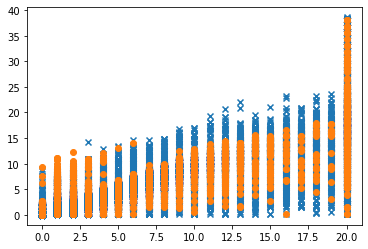

In [128]:
plt.scatter(y_train, lm_train_pred, marker='x')
plt.scatter(y_valid, lm_val_pred, marker='o')
plt.show()

In [129]:
lm_weight = pd.Series(lm.coef_, lm_features)
lm_weight.abs().sort_values(ascending=False)

item_order         37.985
item_price_mean     8.429
item_first_after    2.155
item_first          1.250
lv2_id              0.926
date_block_num      0.873
lv3_id              0.856
new_item            0.301
lv1_id              0.082
item_category_id    0.072
year                0.068
month               0.066
city_id             0.049
shop_id             0.035
item_id             0.013
shop_type_id        0.004
dtype: float32

In [130]:
lm_after_features = list(lm_weight[lm_weight.abs().values>1].index)

<a id='step_knn_sy' href='#content_list'>목차로</a>
### KNN 모델링

In [131]:
# linear regression 기준 coef_이 10 이상인 feature만 selection 하였음

# ['item_id', 'item_cnt_day', 'item_order', 'item_cnt_min', 'item_cnt_max',
#        'item_cnt_mean', 'item_cnt_std', 'item_city_avg_item_cnt_lag_1']

knn_features = lm_after_features
# 훈련용/검증용 셋 분리
X_train_sampled = X_train[:100000]
y_train_sampled = y_train[:100000]

knn_train = X_train_sampled[knn_features]
knn_val = X_valid[knn_features]
knn_test = X_test[knn_features]


# 정규화
knn_scaler = MinMaxScaler()
knn_scaler.fit(knn_train)
knn_train = knn_scaler.transform(knn_train)
knn_val = knn_scaler.transform(knn_val)
knn_test = knn_scaler.transform(knn_test)

In [132]:
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(knn_train, y_train_sampled)

knn_train_pred = knn.predict(knn_train)
knn_val_pred = knn.predict(knn_val)
knn_test_pred = knn.predict(knn_test)

# 평가
print('Train rmse: ', np.sqrt(mean_squared_error(y_train_sampled, knn_train_pred)))
print('Validation rmse: ', np.sqrt(mean_squared_error(y_valid, knn_val_pred)))

Train rmse:  0.19788279
Validation rmse:  0.83723724


In [133]:
print("prediction accuracy: {:.2f}".format(np.mean(knn_val_pred ==y_valid)))

prediction accuracy: 0.92


In [134]:
relation_square=knn.score(knn_train, y_train_sampled)
print('결정계수 R: ', relation_square)

결정계수 R:  0.9698387303208755


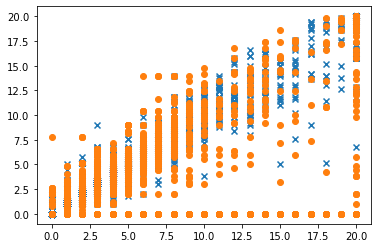

In [135]:
plt.scatter(y_train_sampled, knn_train_pred, marker='x')
plt.scatter(y_valid, knn_val_pred, marker='o')
plt.show()

<a id='step_rf_hy' href='#content_list'>목차로</a>
### Random Forest

In [136]:
# Use only part of features on linear Regression.
rf_features = ['date_block_num',
 'shop_id',
 'item_id',
#  'item_cnt_month',
 'item_order',
 'item_price_mean',
 'city_id',
 'shop_type_id',
 'item_category_id',
 'item_first',
 'lv1_id',
 'lv2_id',
 'lv3_id',
 'year',
 'month',
 'new_item',
 'item_first_after']
#  'item_cnt_d_min',
#  'item_cnt_d_max',
#  'item_cnt_d_mean',
#  'item_cnt_d_std',
#  'item_cnt_di_min',
#  'item_cnt_di_max',
#  'item_cnt_di_mean',
#  'item_cnt_di_std',
#  'item_cnt_ds_min',
#  'item_cnt_ds_max',
#  'item_cnt_ds_mean',
#  'item_cnt_ds_std',
#  'item_cnt_d_min_lag',
#  'item_cnt_d_max_lag',
#  'item_cnt_d_mean_lag',
#  'item_cnt_d_std_lag',
#  'item_cnt_di_min_lag',
#  'item_cnt_di_max_lag',
#  'item_cnt_di_mean_lag',
#  'item_cnt_di_std_lag',
#  'item_cnt_ds_min_lag',
#  'item_cnt_ds_max_lag',
#  'item_cnt_ds_mean_lag',
#  'item_cnt_ds_std_lag',
#  'item_avg_item_cnt',
#  'item_city_avg_item_cnt',
#  'item_shop_avg_item_cnt',
#  'shop_lv1_avg_item_cnt',
#  'item_cnt_month_lag_1',
#  'item_cnt_month_lag_2',
#  'item_cnt_month_lag_3',
#  'item_price_mean_lag_1',
#  'item_price_mean_lag_2',
#  'item_price_mean_lag_3',
#  'item_avg_item_cnt_lag_1',
#  'item_avg_item_cnt_lag_2',
#  'item_avg_item_cnt_lag_3',
#  'item_city_avg_item_cnt_lag_1',
#  'item_city_avg_item_cnt_lag_2',
#  'item_city_avg_item_cnt_lag_3',
#  'item_shop_avg_item_cnt_lag_1',
#  'item_shop_avg_item_cnt_lag_2',
#  'item_shop_avg_item_cnt_lag_3',
#  'shop_lv1_avg_item_cnt_lag_1',
#  'shop_lv1_avg_item_cnt_lag_2',
#  'shop_lv1_avg_item_cnt_lag_3',
#  'item_cnt_month_move_mean_1',
#  'item_cnt_month_move_mean_2',
#  'item_cnt_month_move_mean_3',
#  'item_price_mean_move_mean_1',
#  'item_price_mean_move_mean_2',
#  'item_price_mean_move_mean_3',
#  'item_cnt_month_lag_mean']

In [137]:
rf_train = X_train[rf_features]
rf_val = X_valid[rf_features]
rf_test = X_test[rf_features]

In [138]:
rf_model = RandomForestRegressor(n_estimators=50, max_depth=7, random_state=0, n_jobs=-1)
rf_model.fit(rf_train, y_train)

RandomForestRegressor(max_depth=7, n_estimators=50, n_jobs=-1, random_state=0)

In [139]:
rf_train_pred = rf_model.predict(rf_train)
rf_val_pred = rf_model.predict(rf_val)
rf_test_pred = rf_model.predict(rf_test)

In [140]:
print('Train rmse:', np.sqrt(mean_squared_error(y_train, rf_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(y_valid, rf_val_pred)))

Train rmse: 0.2555291758902208
Validation rmse: 0.2834232676829161


<a id='step_xgboost_jy' href='#content_list'>목차로</a>
### XGboost

In [208]:
xgb_features = ['date_block_num',
#  'shop_id',
 'item_id',
#  'item_cnt_month',
 'item_order',
 'item_price_mean',
#  'city_id',
 'shop_type_id',
#  'item_category_id',
#  'item_first',
 'lv1_id',
 'lv2_id',
 'lv3_id',
#  'year',
#  'month',
 'new_item',
 'item_first_after',
#  'item_cnt_d_min',
#  'item_cnt_d_max',
#  'item_cnt_d_mean',
#  'item_cnt_d_std',
#  'item_cnt_di_min',
#  'item_cnt_di_max',
#  'item_cnt_di_mean',
#  'item_cnt_di_std',
#  'item_cnt_ds_min',
#  'item_cnt_ds_max',
#  'item_cnt_ds_mean',
#  'item_cnt_ds_std',
 'item_cnt_d_min_lag',
 'item_cnt_d_max_lag',
 'item_cnt_d_mean_lag',
 'item_cnt_d_std_lag',
 'item_cnt_di_min_lag',
 'item_cnt_di_max_lag',
 'item_cnt_di_mean_lag',
 'item_cnt_di_std_lag',
 'item_cnt_ds_min_lag',
 'item_cnt_ds_max_lag',
 'item_cnt_ds_mean_lag',
 'item_cnt_ds_std_lag',
 'item_avg_item_cnt',
 'item_city_avg_item_cnt',
 'item_shop_avg_item_cnt',
 'shop_lv1_avg_item_cnt',
 'item_cnt_month_lag_1',
 'item_cnt_month_lag_2',
 'item_cnt_month_lag_3',
 'item_price_mean_lag_1',
 'item_price_mean_lag_2',
 'item_price_mean_lag_3',
 'item_avg_item_cnt_lag_1',
 'item_avg_item_cnt_lag_2',
 'item_avg_item_cnt_lag_3',
 'item_city_avg_item_cnt_lag_1',
 'item_city_avg_item_cnt_lag_2',
 'item_city_avg_item_cnt_lag_3',
 'item_shop_avg_item_cnt_lag_1',
 'item_shop_avg_item_cnt_lag_2',
 'item_shop_avg_item_cnt_lag_3',
 'shop_lv1_avg_item_cnt_lag_1',
 'shop_lv1_avg_item_cnt_lag_2',
 'shop_lv1_avg_item_cnt_lag_3',
 'item_cnt_month_move_mean_1',
 'item_cnt_month_move_mean_2',
 'item_cnt_month_move_mean_3',
 'item_price_mean_move_mean_1',
 'item_price_mean_move_mean_2',
 'item_price_mean_move_mean_3',
 'item_cnt_month_lag_mean']

In [164]:
# xgb_features = ['date_block_num',
#                'shop_id_0',
# #                'shop_id_1',
#                'shop_id_2',
#                'shop_id_3',
#                'shop_id_4',
#                'shop_id_5',
# #                'item_id_0',
#                'item_id_1',
#                'item_id_2',
#                'item_id_3',
#                'item_id_4',
#                'item_id_5',
# #                'item_id_6',
#                'item_id_7',
#                'item_id_8',
#                'item_id_9',
# #                'item_id_10',
# #                'item_id_11',
#                'item_id_12',
# #                'date',
#                'item_price',
#                'item_cnt_day',
#                'city_id',
#                'shop_type_id',
#                'item_category_id_0',
#                'item_category_id_1',
#                'item_category_id_2',
# #                'item_category_id_3',
#                'item_category_id_4',
#                'item_category_id_5',
#                'item_first',
#                'lv1_id',
#                'lv2_id',
#                'lv3_id',
#                'year_0',
#                'year_1',
#                'month_0',
#                'month_1',
#                'month_2',
#                'month_3',
#                'item_order',
#                'item_price_mean',
#                'new_item',
#                'item_cnt_min',
#                'item_cnt_max',
#                'item_cnt_mean',
# #                'item_cnt_std',
# #                'item_first_after',
#                'item_cnt_month_lag_1',
#                'item_cnt_month_lag_2',
#                'item_cnt_month_lag_3',
#                'item_price_mean_lag_1',
#                'item_price_mean_lag_2',
#                'item_price_mean_lag_3',
#                'item_avg_item_cnt_lag_1',
#                'item_avg_item_cnt_lag_2',
#                'item_avg_item_cnt_lag_3',
#                'item_city_avg_item_cnt_lag_1',
# #                'item_city_avg_item_cnt_lag_2',
#                'item_city_avg_item_cnt_lag_3',
#                'item_shop_avg_item_cnt_lag_1',
#                'item_shop_avg_item_cnt_lag_2',
#                'item_shop_avg_item_cnt_lag_3',
#                'shop_lv1_avg_item_cnt_lag_1',
#                'shop_lv1_avg_item_cnt_lag_2',
#                'shop_lv1_avg_item_cnt_lag_3',
# #                'ID',
# #                'shop_id',
# #                'item_id'
#                ]

In [143]:
df_basis_monthly2 = df_basis_monthly.copy()

In [144]:
# df_basis_monthly2.drop(columns = ['item_cnt_month_lag_mean',
#                         'item_cnt_month_lag_3','item_cnt_month_lag_1',
#                         'item_cnt_month_lag_2','item_first','item_cnt_ds_min',
#                         'item_cnt_d_min', 'item_first_after'], inplace=True)

In [145]:
df_basis_monthly2['year'].replace({2013:1,2014:2,2015:3},inplace=True) #숫자가 너무 크기 때문에 숫자크기 줄여줌 

#Import the libraries
import category_encoders as ce

#Create object for binary encoding  # 바이너리 인코딩 #숫자형이지만 카테고리인 feature 넣어주기
encoder= ce.BinaryEncoder(cols=['year','month','shop_id', 'item_id', 'item_category_id'],return_df=True) 

#Fit and Transform Data    
df_basis_monthly2=encoder.fit_transform(df_basis_monthly2) 

In [146]:
df_basis_monthly2 = reduce_mem_usage(df_basis_monthly2)

Memory usage of dataframe is 2302.20 MB --> 1282.66 MB (Decreased by 44.3%)


train,test,validation
- 0~32개월까지는 train data
- 33개월은 validation data
- 34개월은 test data

In [147]:
train_set2 = df_basis_monthly2[df_basis_monthly2.date_block_num < 33].copy()
validation_set2 = df_basis_monthly2[df_basis_monthly2.date_block_num == 33].copy()
test_set2 = df_basis_monthly2[df_basis_monthly2.date_block_num == 34].copy()

In [148]:
print('Train set2 records:', train_set2.shape[0])
print('Validation set2 records:', validation_set2.shape[0])
print('Test set2 records:', test_set2.shape[0])

print('Train set2 records: %s (%.f%% of complete data)' % (train_set2.shape[0], ((train_set2.shape[0]/df_basis_monthly2.shape[0])*100)))
print('Validation set2 records: %s (%.f%% of complete data)' % (validation_set2.shape[0], ((validation_set2.shape[0]/df_basis_monthly2.shape[0])*100)))

Train set2 records: 4498200
Validation set2 records: 214200
Test set2 records: 214200
Train set2 records: 4498200 (91% of complete data)
Validation set2 records: 214200 (4% of complete data)


In [149]:
### 최종 분리!!
# 훈련데이터 (피처)
X_train2 = train_set2.drop(['item_cnt_month'], axis=1)
# 훈련데이터 (타깃값)
y_train2 = train_set2['item_cnt_month']  # 독립변수 Y
y_train2 = y_train2.clip(0,20)  # 타깃값을 0~20으로 제한

# 검증 데이터 (피처)
X_valid2 = validation_set2.drop(['item_cnt_month'], axis=1)  # 검증용 
# 검증 데이터 (타깃값)
y_valid2 = validation_set2['item_cnt_month']
y_valid2 = y_valid2.clip(0,20)  # 타깃값을 0~20으로 제한

# 테스트 데이터(피처)
X_test2 = test_set2.drop(['item_cnt_month'], axis=1)

In [150]:
# 다중 공선성
def get_vif(formula, df):
    from patsy import dmatrices
    y, X = dmatrices(formula, df, return_type = "dataframe")
    vif = pd.DataFrame()
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    vif['VIF Factor'] = [variance_inflation_factor(X.values, i)
                        for i in range(X.shape[1])]
    vif['features'] = X.columns
    vif.sort_values(by='VIF Factor', ascending = False, inplace = True)
    return vif

In [ ]:
formula = "item_cnt_month~" + "+".join(validation_set.drop(['item_cnt_month'], 
                                                           axis=1).columns) + "-1"
get_vif(formula, validation_set)

In [ ]:
formula = "item_cnt_month~" + "+".join(validation_set.drop(['item_cnt_month'], 
                                                           axis=1).columns) + "-1"
get_vif(formula, validation_set)

In [ ]:
import statsmodels.formula.api as smf
formula = "item_cnt_month~" + "+".join(xgb_features) + "-1"
model_summary = smf.ols(formula=formula, data=validation_set, axis=1).fit()
model_summary.summary()

In [152]:
xgb_train = X_train[xgb_features]
xgb_val = X_valid[xgb_features]
xgb_test = X_test[xgb_features]

In [ ]:
import statsmodels.formula.api as smf
formula = "item_cnt_month~" + "+".join(validation_set.drop(['item_cnt_month'], axis=1).columns) + "-1"
model_summary = smf.ols(formula=formula, data=validation_set).fit()
model_summary.summary()

- Durbin-Watson 통계량 : 0에 가까울수록 양의 자기상관, 4에 가까울수록 음의 자기상관이 있다고 판단
- 2에 가까울 수록 자기상관이 없다고 판단
- 보통 1.5~2.5 사이의 값을 적용

- Durbin-Watson : 
1.730이므로 자기상관이 없다고 할 수 있다
‘잔차항들은 서로 독립이다’라는 가정을 만족한다

- R-squared : 결정계수, 전체 데이터 중 해당 회귀모델이 설명할 수 있는 데이터의 비율 회귀식의 설명력을 나타낸다.
    성능을 나타냄 ( 1에 가까울수록 성능이 좋음)
    - 0.948로 전체 데이터 중 해당 회귀모델을 잘 설명하고 있다
- Adj.R-Squared : 모델에 도움이 되는 데이터에 따라 조정된 결정계수
    - 94.8% 
- F-statistic : F 통계량으로 도출된 회귀식이 적절한지 볼 수 있음. 0과 가까울 수록 적절
    - 4.999e+0.5 ..?
- Prob(F-statistic) : 회귀식이 유의미한지 판단 (0.05 이하일 경우 변수끼리 매우 관련있다고 판단)
    - 0.00으로 F 통계량으로 도출된 회귀식이 유의미하다고 할 수 있다.(<0.05)
- AIC : 표본의 개수와 모델의 복잡성을 기반으로 한 모델을 평가, 수치가 낮을 수록 좋음
- BIC : AIC와 유사하나 패널티를 부여하여 AIC보다 모델 평가 성능이 더 좋고, 수치가 낮을 수록 좋음

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.76e-20. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.

해석:
[1] 표준 오차는 오차의 공분산 행렬이 올바르게 지정되었다고 가정합니다.

[2] 가장 작은 고윳값은  6.76e-20입니다. 이것은 강한 다중공선성이 있거나, matrix 디자인이 특이행렬(singular matrix) -> 행렬식이 0 ( 역행렬이 존재하지 않음 )

xgb modeling

In [155]:
xgb_train = X_train[xgb_features]
xgb_val = X_valid[xgb_features]
xgb_test = X_test[xgb_features]

In [156]:
xgb_model = XGBRegressor(max_depth=8, # 개별 트리의 최대 깊이 (과대적합을 제어하는 파라미터, 깊을수록 복잡해지고 과대적합, 3~10사용)
                         n_estimators=1000,  # 결정 트리 개수
                         min_child_weight=300,   # 과대적합 방지
                         colsample_bytree=0.8,  # 개별 트리를 훈련할 때 사용하는 피처 샘플링 비율
                         subsample=0.8,   # 개별 트리를 훈련할 때 사용할 데이터 샘플링 비율
                         eta=0.3,  # 학습률
                         seed=42)
xgb_model.fit(xgb_train, 
              y_train, 
              eval_metric="rmse", 
              eval_set=[(xgb_train, y_train), (xgb_val, y_valid)], 
              verbose=20)

C:\Users\yes47\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:0.81599	validation_1-rmse:0.81036
[20]	validation_0-rmse:0.21740	validation_1-rmse:0.23481
[40]	validation_0-rmse:0.20745	validation_1-rmse:0.22962
[60]	validation_0-rmse:0.20179	validation_1-rmse:0.22686
[80]	validation_0-rmse:0.19778	validation_1-rmse:0.22241
[100]	validation_0-rmse:0.19494	validation_1-rmse:0.22041
[120]	validation_0-rmse:0.19262	validation_1-rmse:0.21950
[140]	validation_0-rmse:0.19031	validation_1-rmse:0.21766
[160]	validation_0-rmse:0.18854	validation_1-rmse:0.21624
[180]	validation_0-rmse:0.18693	validation_1-rmse:0.21520
[200]	validation_0-rmse:0.18534	validation_1-rmse:0.21436
[220]	validation_0-rmse:0.18416	validation_1-rmse:0.21367
[240]	validation_0-rmse:0.18302	validation_1-rmse:0.21334
[260]	validation_0-rmse:0.18177	validation_1-rmse:0.21272
[280]	validation_0-rmse:0.18064	validation_1-rmse:0.21221
[300]	validation_0-rmse:0.17959	validation_1-rmse:0.21202
[320]	validation_0-rmse:0.17853	validation_1-rmse:0.21146
[340]	validation_0-r

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
             early_stopping_rounds=None, enable_categorical=False, eta=0.3,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=8, max_leaves=0, min_child_weight=1000,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0, ...)

In [157]:
xgb_train_pred = xgb_model.predict(xgb_train)
xgb_val_pred = xgb_model.predict(xgb_val)
xgb_test_pred = xgb_model.predict(xgb_test)

print('Train rmse:', np.sqrt(mean_squared_error(y_train, xgb_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(y_valid, xgb_val_pred)))

Train rmse: 0.1709829
Validation rmse: 0.20836246


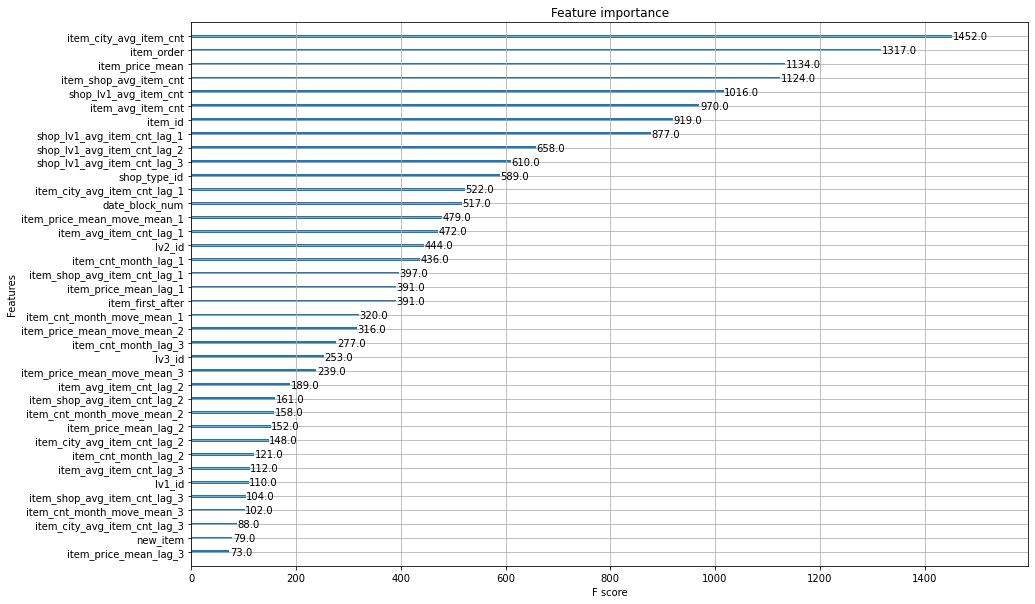

In [158]:
plt.rcParams["figure.figsize"] = (15, 10)
plot_importance(xgb_model)
plt.show()

------------------------------------------

----------------------------------------

3차
category_encoders 한 경우
<br>
Train rmse: 0.07840425207783387
Validation rmse: 0.09929263594139327

2차

#### 결과1 category_encoders 안함
Train rmse: 0.07739215395785341
Validation rmse: 0.09882664163456827

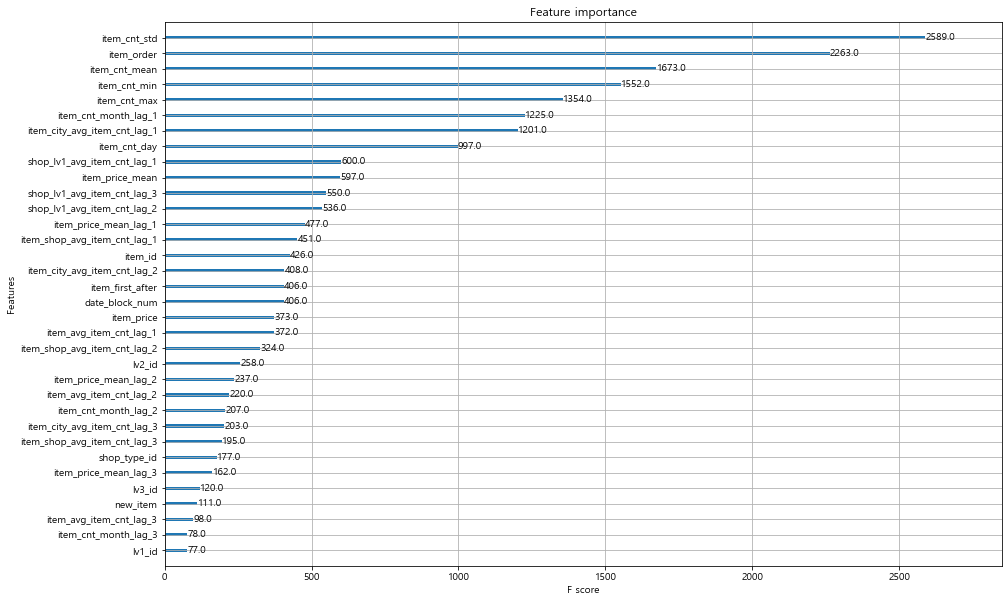

#### 결과2 category_encoders 함
Train rmse: 0.08350034967210976
Validation rmse: 0.10582890536221212

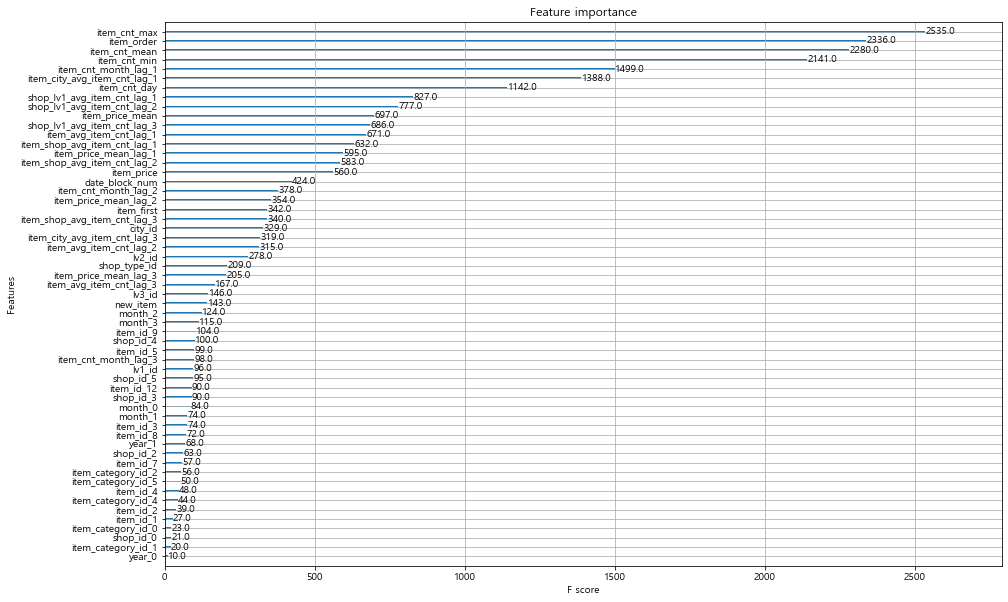

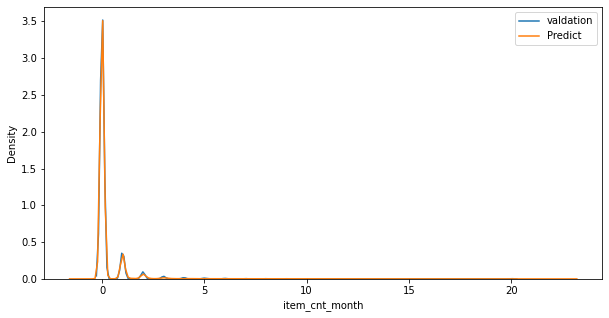

In [165]:
plt.figure(figsize = (10, 5))
sns.distplot(y_valid, label = 'valdation', hist = False)
sns.distplot(xgb_val_pred, label = 'Predict', hist = False)
plt.legend()
plt.show()

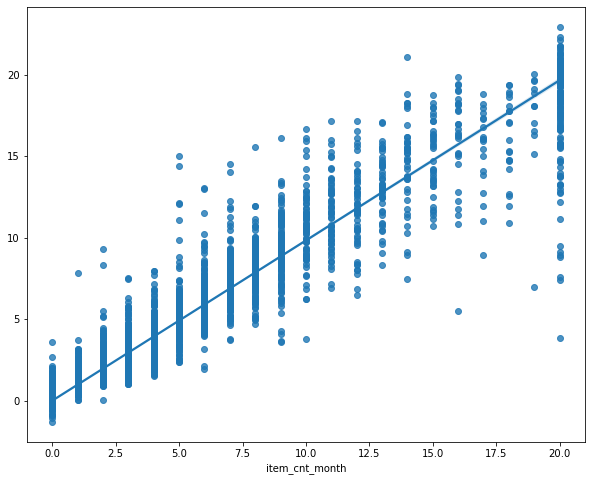

In [166]:
plt.figure(figsize = (10, 8))
sns.regplot(y_valid, xgb_val_pred)
plt.show()

잔차 정규성

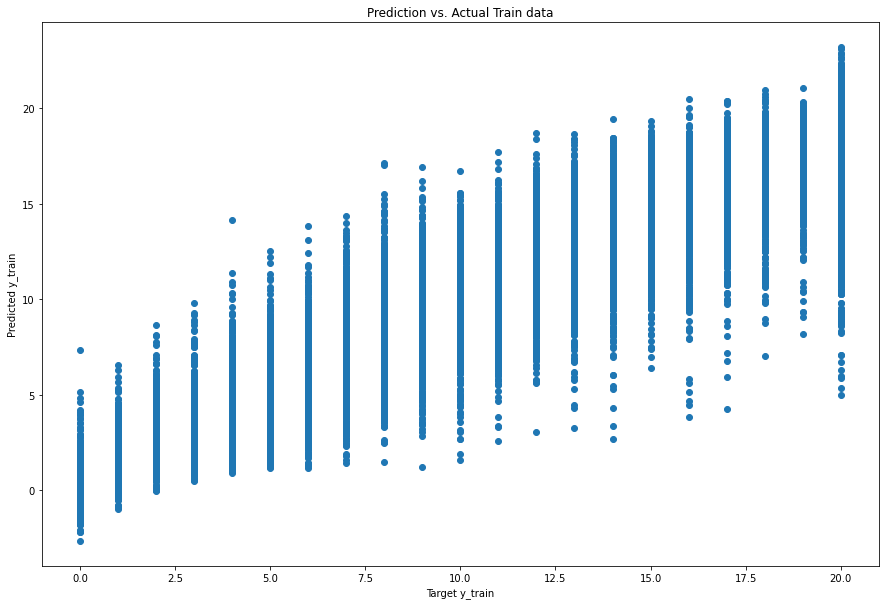

In [167]:
# train - 잔차 정규성
fig = plt.figure
plt.scatter(y_train, xgb_train_pred)
plt.xlabel("Target y_train")
plt.ylabel("Predicted y_train")
plt.title('Prediction vs. Actual Train data')
plt.show()

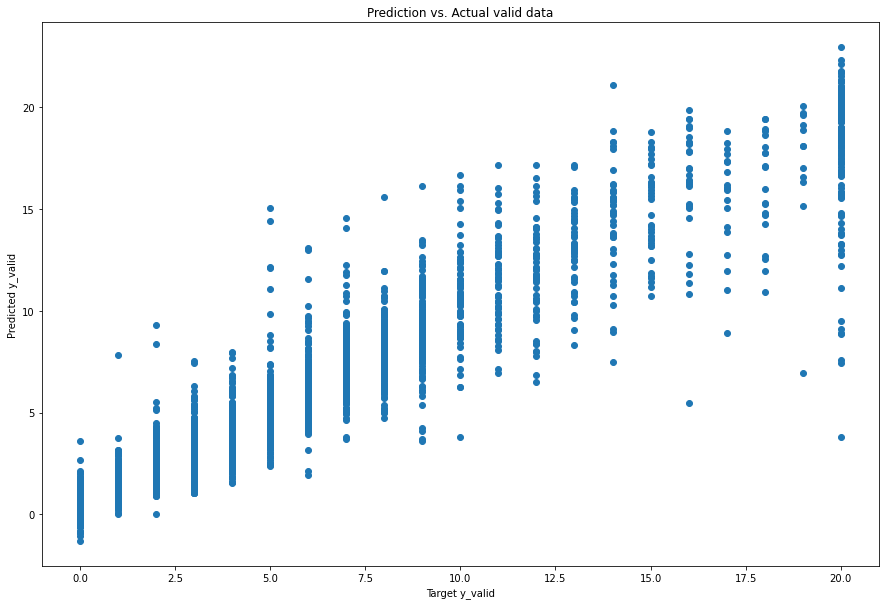

In [168]:
# validation - 잔차 정규성
fig = plt.figure
plt.scatter(y_valid, xgb_val_pred)
plt.xlabel("Target y_valid")
plt.ylabel("Predicted y_valid")
plt.title('Prediction vs. Actual valid data')
plt.show()

P-P 도표

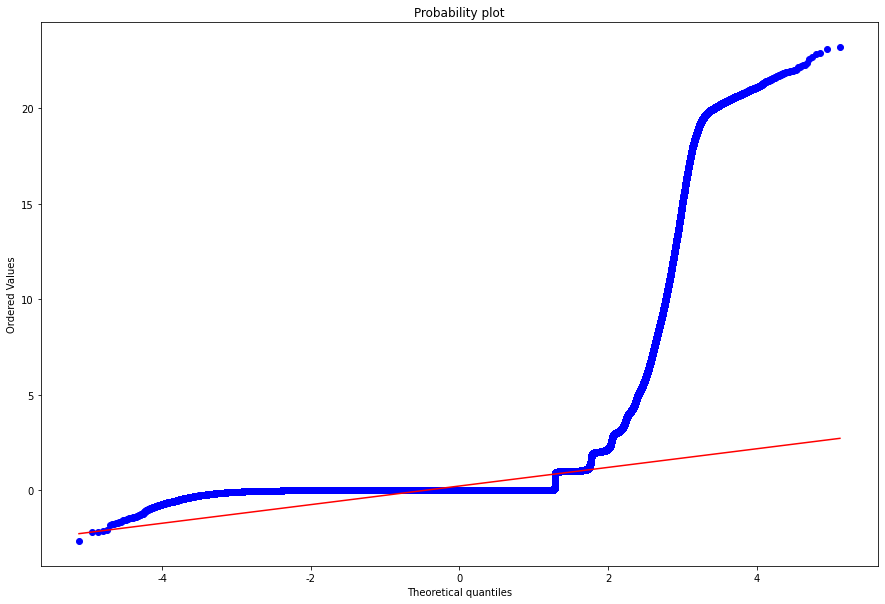

In [169]:
# xgb_train_pred P-P 도표
from scipy import stats

fig = plt.figure()
res = stats.probplot(xgb_train_pred, plot=plt)
plt.title('Probability plot')
plt.show()

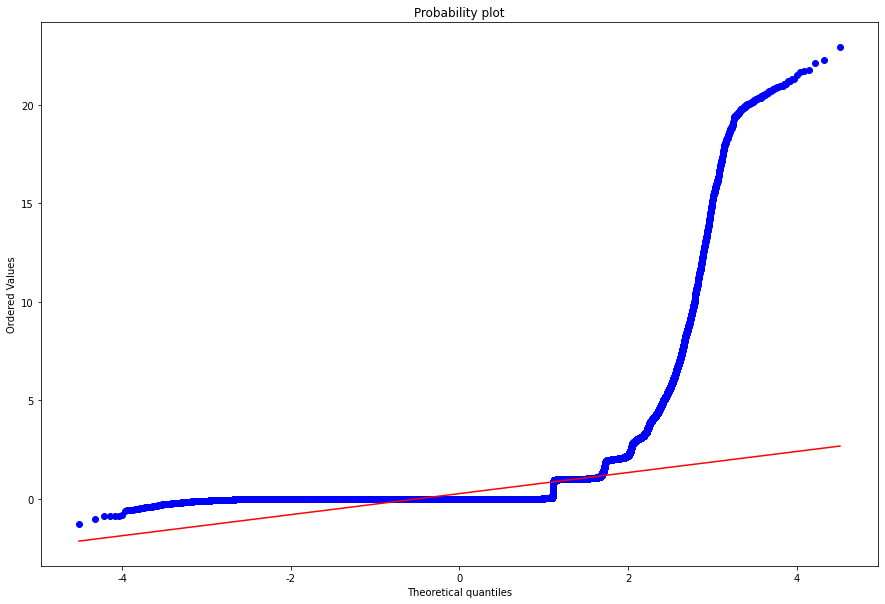

In [170]:
# xgb_val_pred P-P 도표
from scipy import stats

fig = plt.figure()
res = stats.probplot(xgb_val_pred, plot=plt)
plt.title('Probability plot')
plt.show()

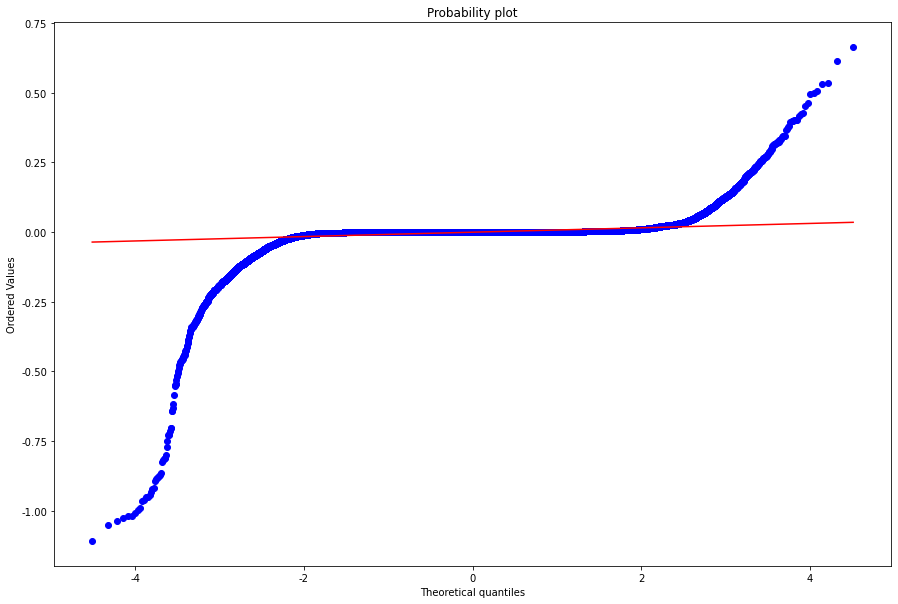

In [171]:
# xgb_test_pred P-P 도표
from scipy import stats

fig = plt.figure()
res = stats.probplot(xgb_test_pred, plot=plt)
plt.title('Probability plot')
plt.show()

<a id='step_lgbm_dy' href='#content_list'>목차로</a>
### LightGBM

In [172]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4498200 entries, 0 to 4498199
Data columns (total 69 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   date_block_num                int8   
 1   shop_id                       int8   
 2   item_id                       int16  
 3   item_order                    int8   
 4   item_price_mean               float32
 5   city_id                       int8   
 6   shop_type_id                  int8   
 7   item_category_id              int8   
 8   item_first                    int8   
 9   lv1_id                        int8   
 10  lv2_id                        int8   
 11  lv3_id                        int8   
 12  year                          int16  
 13  month                         int8   
 14  new_item                      int8   
 15  item_first_after              int8   
 16  item_cnt_d_min                float32
 17  item_cnt_d_max                float32
 18  item_cnt_d_mean       

In [173]:
X_valid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214200 entries, 4498200 to 4712399
Data columns (total 69 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   date_block_num                214200 non-null  int8   
 1   shop_id                       214200 non-null  int8   
 2   item_id                       214200 non-null  int16  
 3   item_order                    214200 non-null  int8   
 4   item_price_mean               214200 non-null  float32
 5   city_id                       214200 non-null  int8   
 6   shop_type_id                  214200 non-null  int8   
 7   item_category_id              214200 non-null  int8   
 8   item_first                    214200 non-null  int8   
 9   lv1_id                        214200 non-null  int8   
 10  lv2_id                        214200 non-null  int8   
 11  lv3_id                        214200 non-null  int8   
 12  year                          214200 

In [174]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214200 entries, 4712400 to 4926599
Data columns (total 69 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   date_block_num                214200 non-null  int8   
 1   shop_id                       214200 non-null  int8   
 2   item_id                       214200 non-null  int16  
 3   item_order                    214200 non-null  int8   
 4   item_price_mean               214200 non-null  float32
 5   city_id                       214200 non-null  int8   
 6   shop_type_id                  214200 non-null  int8   
 7   item_category_id              214200 non-null  int8   
 8   item_first                    214200 non-null  int8   
 9   lv1_id                        214200 non-null  int8   
 10  lv2_id                        214200 non-null  int8   
 11  lv3_id                        214200 non-null  int8   
 12  year                          214200 

In [175]:
X_train.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_order', 'item_price_mean',
       'city_id', 'shop_type_id', 'item_category_id', 'item_first', 'lv1_id',
       'lv2_id', 'lv3_id', 'year', 'month', 'new_item', 'item_first_after',
       'item_cnt_d_min', 'item_cnt_d_max', 'item_cnt_d_mean', 'item_cnt_d_std',
       'item_cnt_di_min', 'item_cnt_di_max', 'item_cnt_di_mean',
       'item_cnt_di_std', 'item_cnt_ds_min', 'item_cnt_ds_max',
       'item_cnt_ds_mean', 'item_cnt_ds_std', 'item_cnt_d_min_lag',
       'item_cnt_d_max_lag', 'item_cnt_d_mean_lag', 'item_cnt_d_std_lag',
       'item_cnt_di_min_lag', 'item_cnt_di_max_lag', 'item_cnt_di_mean_lag',
       'item_cnt_di_std_lag', 'item_cnt_ds_min_lag', 'item_cnt_ds_max_lag',
       'item_cnt_ds_mean_lag', 'item_cnt_ds_std_lag', 'item_avg_item_cnt',
       'item_city_avg_item_cnt', 'item_shop_avg_item_cnt',
       'shop_lv1_avg_item_cnt', 'item_cnt_month_lag_1', 'item_cnt_month_lag_2',
       'item_cnt_month_lag_3', 'item_price_mean_

In [180]:
lgbm_features= ['date_block_num', 'shop_id', 'item_id', 'item_order',
       'item_price_mean', 'city_id', 'shop_type_id', 'item_category_id',
       'lv1_id', 'lv2_id', 'lv3_id', 'year', 'month', 'new_item',
       'item_cnt_d_max', 'item_cnt_d_mean', 'item_cnt_d_std',
       'item_cnt_di_min', 'item_cnt_di_max', 'item_cnt_di_mean',
       'item_cnt_di_std', 'item_cnt_ds_max', 'item_cnt_ds_mean',
       'item_cnt_ds_std', 'item_avg_item_cnt', 'item_city_avg_item_cnt',
       'item_shop_avg_item_cnt', 'shop_lv1_avg_item_cnt',
       'item_price_mean_lag_1', 'item_price_mean_lag_2',
       'item_price_mean_lag_3', 'item_avg_item_cnt_lag_1',
       'item_avg_item_cnt_lag_2', 'item_avg_item_cnt_lag_3',
       'item_city_avg_item_cnt_lag_1', 'item_city_avg_item_cnt_lag_2',
       'item_city_avg_item_cnt_lag_3', 'item_shop_avg_item_cnt_lag_1',
       'item_shop_avg_item_cnt_lag_2', 'item_shop_avg_item_cnt_lag_3',
       'shop_lv1_avg_item_cnt_lag_1', 'shop_lv1_avg_item_cnt_lag_2',
       'shop_lv1_avg_item_cnt_lag_3', 'item_cnt_month_move_mean_1',
       'item_cnt_month_move_mean_2', 'item_cnt_month_move_mean_3',
       'item_price_mean_move_mean_1', 'item_price_mean_move_mean_2',
       'item_price_mean_move_mean_3']

In [176]:
# lgbm_features = ['item_city_avg_item_cnt', 'item_cnt_d_mean', 'item_cnt_di_std',
#        'item_cnt_d_max', 'item_cnt_di_mean', 'item_price_mean',
#        'item_shop_avg_item_cnt', 'item_order', 'item_cnt_di_max',
#        'item_cnt_d_std', 'item_avg_item_cnt',
#        'shop_lv1_avg_item_cnt', 'item_cnt_di_min',
#        'shop_lv1_avg_item_cnt_lag_2', 'shop_lv1_avg_item_cnt_lag_1',
#        'item_cnt_d_min', 'item_price_mean_move_mean_1',
#        'shop_lv1_avg_item_cnt_lag_3', 'city_id', 'item_cnt_di_std_lag',
#        'item_cnt_d_mean_lag', 'item_cnt_d_std_lag',
#        'item_city_avg_item_cnt_lag_1',
#        'month_1',
#        'item_shop_avg_item_cnt_lag_1', 'item_cnt_di_mean_lag', 'shop_type_id',
#        'item_cnt_month_lag_1', 'item_price_mean_move_mean_2',
#        'item_cnt_month_move_mean_2',
#        'item_price_mean_lag_1', 'item_first', 'item_avg_item_cnt_lag_1',
#        'item_cnt_d_max_lag',
#        'item_cnt_month_move_mean_3',
#        'date_block_num', 'item_price_mean_move_mean_3', 'item_cnt_ds_std_lag',
#        'lv2_id', 'shop_id_4',
#        'item_city_avg_item_cnt_lag_2',
#        'item_cnt_di_max_lag', 'item_cnt_di_min_lag',
#        'item_shop_avg_item_cnt_lag_2', 'item_first_after',
#        'item_cnt_d_min_lag', 'item_cnt_month_lag_2', 'item_price_mean_lag_2',
#        'shop_id_5', 'item_avg_item_cnt_lag_2',
#        'item_cnt_ds_std',
#        'item_cnt_month_move_mean_1', 'shop_id_3',
#        'shop_id_1', 'shop_id_2',
#        'item_shop_avg_item_cnt_lag_3',
#        'item_cnt_month_lag_3', 'item_city_avg_item_cnt_lag_3', 'item_id_11',
#        'item_price_mean_lag_3', 'item_avg_item_cnt_lag_3', 'item_id_10',
#        'item_id_12', 'item_cnt_ds_max', 'item_cnt_ds_mean',
#        'item_category_id_5', 'item_id_5',
#        'item_id_2', 'item_id_3', 'item_id_8', 'item_id_9', 'item_id_4',
#        'item_id_6', 'item_id_7', 'item_category_id_2', 'lv1_id', 'month_3',
#        'item_category_id_4', 'lv3_id', 'month_2', 'item_category_id_3',
#        'month_0', 'item_cnt_ds_min', 'item_category_id_1'
#                     ]

In [181]:
lgbm_X_train = X_train[lgbm_features]
lgbm_X_valid = X_valid[lgbm_features]
lgbm_X_test = X_test[lgbm_features]

In [182]:
lgbm_y_train = y_train
lgbm_y_valid = y_valid

In [183]:
params={'learning_rate': 0.05,
        'objective':'regression',
        'metric':'rmse',
        'num_leaves': 64,
        'verbose': 1,
        'random_state':42,
        'bagging_fraction': 1,
        'feature_fraction': 1
       }
# learning_rate >> 부스팅 스탭 반복할 때 학습률, 0~1 사이의 값
# objective     >> 수치예측이면 regression, 이진분류이면 binary
# metric        >> 성능평가를 어떤 것으로 할 것인지 (auc, l1, l2 등)
# num_leaves    >> 하나의 트리가 가질 수 있는 최대 리프 개수
#                  클수록 정확도는 높아지지만 오버피팅 발생 가능
# bagging_fraction  >> 데이터 샘플링 비율, 오버피팅 제어
# feature_fraction  >> 개별 트리 학습 시 무작위로 선택하는 feature의 비율

In [184]:
reg = lgb.LGBMRegressor(**params, n_estimators=3000)
reg.fit(lgbm_X_train, lgbm_y_train,
        eval_set = [(lgbm_X_valid, lgbm_y_valid)],
        early_stopping_rounds=50,
        verbose=500
       )

C:\Users\yes47\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yes47\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.572274 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7963
[LightGBM] [Info] Number of data points in the train set: 4498200, number of used features: 49
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] bagging_fraction is set=1, subsampl

LGBMRegressor(bagging_fraction=1, feature_fraction=1, learning_rate=0.05,
              metric='rmse', n_estimators=3000, num_leaves=64,
              objective='regression', random_state=42, verbose=1)

In [185]:
# 예측 : 시간 좀 걸림
lgbm_train_pred = reg.predict(lgbm_X_train.values, num_iteration=reg.best_iteration_)
lgbm_valid_pred = reg.predict(lgbm_X_valid.values, num_iteration=reg.best_iteration_)
lgbm_test_pred = reg.predict(lgbm_X_test.values, num_iteration=reg.best_iteration_)

In [186]:
# 모델이 잘 훈련되었는지, 확인
print('Train rmse:', np.sqrt(mean_squared_error(lgbm_y_train, lgbm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(lgbm_y_valid, lgbm_valid_pred))) 

Train rmse: 0.03057195080585991
Validation rmse: 0.07909032447077484


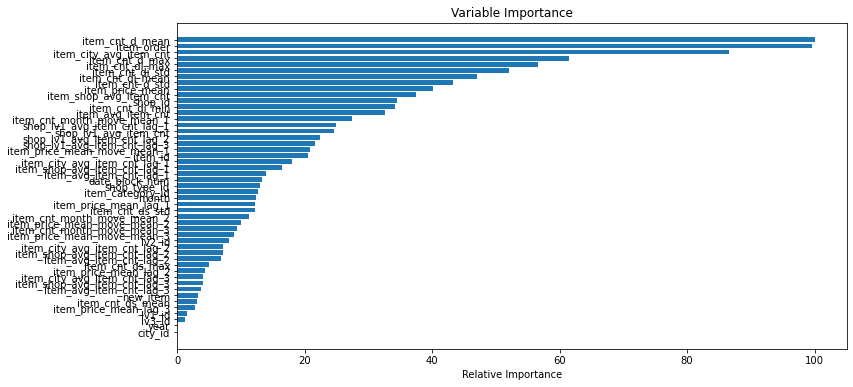

In [187]:
# 각 피처들의 중요도
feature_importance = reg.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(12,6))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, lgbm_X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [188]:
# 피처 중요도 우선순위
new_sorted_idx = np.argsort(feature_importance)[::-1]
lgbm_X_train.columns[new_sorted_idx[:-10]]

Index(['item_cnt_d_mean', 'item_order', 'item_city_avg_item_cnt',
       'item_cnt_d_max', 'item_cnt_di_max', 'item_cnt_di_std',
       'item_cnt_di_mean', 'item_cnt_d_std', 'item_price_mean',
       'item_shop_avg_item_cnt', 'shop_id', 'item_cnt_di_min',
       'item_avg_item_cnt', 'item_cnt_month_move_mean_1',
       'shop_lv1_avg_item_cnt_lag_1', 'shop_lv1_avg_item_cnt',
       'shop_lv1_avg_item_cnt_lag_2', 'shop_lv1_avg_item_cnt_lag_3',
       'item_price_mean_move_mean_1', 'item_id',
       'item_city_avg_item_cnt_lag_1', 'item_shop_avg_item_cnt_lag_1',
       'item_avg_item_cnt_lag_1', 'date_block_num', 'shop_type_id',
       'item_category_id', 'month', 'item_price_mean_lag_1', 'item_cnt_ds_std',
       'item_cnt_month_move_mean_2', 'item_price_mean_move_mean_2',
       'item_cnt_month_move_mean_3', 'item_price_mean_move_mean_3', 'lv2_id',
       'item_city_avg_item_cnt_lag_2', 'item_shop_avg_item_cnt_lag_2',
       'item_avg_item_cnt_lag_2', 'item_cnt_ds_max', 'item_price_mean

#### 주영
Train rmse: 0.024155989390604784
Validation rmse: 0.061952393979809645

##### 결과 1 : category_encoders 안함
> 학습
- ...
- [LightGBM] [Info] Start training from score 0.825693
- [500]	valid_0's rmse: 0.156025

> 결과
- Train rmse: 0.0871333880990032
- Validation rmse: 0.15449852039049203

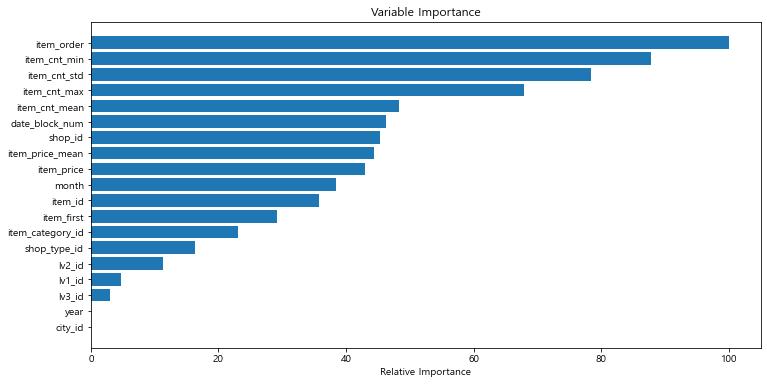

##### 결과 2 : category_encoders 함
> 학습
- ...
- [LightGBM] [Info] Start training from score 0.825693
- [500]	valid_0's rmse: 0.124946

> 결과
- Train rmse: 0.07736622736165054
- Validation rmse: 0.1232819374945341

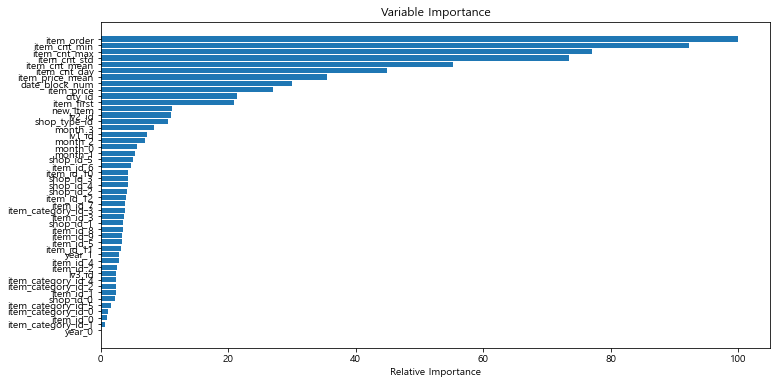

<a id='step_6' href='#content_list'>목차로</a>
## 6. 앙상블

In [ ]:
# oof_test_preds = oof_test_preds_lgb * 0.5, oof_test_preds_xgb * 0.5

GridSearchCV

In [159]:
# params = {
#     'learning_rate': [0.04, 0.05, 0.06],
#     'min_child_weight': [800, 1000, 1200],
#     'max_depth': [3, 4, 5],
#     'colsample_bytree': [0.8, 0.85, 0.9],
#     'subsample': [0.8, 0.85, 0.9],
# }

In [160]:
# from sklearn.model_selection import GridSearchCV
# grid_search = GridSearchCV(XGBRegressor(), params, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

In [161]:
# grid_search.fit(x_train, y_train)

In [162]:
# grid_search.best_score_

In [163]:
# grid_search.best_params_

In [189]:
ens_features = ['date_block_num', 'shop_id', 'item_id', 'item_order',
       'item_price_mean', 'city_id', 'shop_type_id', 'item_category_id',
       'lv1_id', 'lv2_id', 'lv3_id', 'year', 'month', 'new_item',
       'item_cnt_d_max', 'item_cnt_d_mean', 'item_cnt_d_std',
       'item_cnt_di_min', 'item_cnt_di_max', 'item_cnt_di_mean',
       'item_cnt_di_std', 'item_cnt_ds_max', 'item_cnt_ds_mean',
       'item_cnt_ds_std', 'item_avg_item_cnt', 'item_city_avg_item_cnt',
       'item_shop_avg_item_cnt', 'shop_lv1_avg_item_cnt',
       'item_price_mean_lag_1', 'item_price_mean_lag_2',
       'item_price_mean_lag_3', 'item_avg_item_cnt_lag_1',
       'item_avg_item_cnt_lag_2', 'item_avg_item_cnt_lag_3',
       'item_city_avg_item_cnt_lag_1', 'item_city_avg_item_cnt_lag_2',
       'item_city_avg_item_cnt_lag_3', 'item_shop_avg_item_cnt_lag_1',
       'item_shop_avg_item_cnt_lag_2', 'item_shop_avg_item_cnt_lag_3',
       'shop_lv1_avg_item_cnt_lag_1', 'shop_lv1_avg_item_cnt_lag_2',
       'shop_lv1_avg_item_cnt_lag_3', 'item_cnt_month_move_mean_1',
       'item_cnt_month_move_mean_2', 'item_cnt_month_move_mean_3',
       'item_price_mean_move_mean_1', 'item_price_mean_move_mean_2',
       'item_price_mean_move_mean_3']

In [190]:
# ens_features = ['item_city_avg_item_cnt', 'item_cnt_d_mean', 'item_cnt_di_std',
#        'item_cnt_d_max', 'item_cnt_di_mean', 'item_price_mean',
#        'item_shop_avg_item_cnt', 'item_order', 'item_cnt_di_max',
#        'item_cnt_d_std', 'item_avg_item_cnt',
#        'shop_lv1_avg_item_cnt', 'item_cnt_di_min',
#        'shop_lv1_avg_item_cnt_lag_2', 'shop_lv1_avg_item_cnt_lag_1',
#        'item_cnt_d_min', 'item_price_mean_move_mean_1',
#        'shop_lv1_avg_item_cnt_lag_3', 'city_id', 'item_cnt_di_std_lag',
#        'item_cnt_d_mean_lag', 'item_cnt_d_std_lag',
#        'item_city_avg_item_cnt_lag_1',
#        'month_1',
#        'item_shop_avg_item_cnt_lag_1', 'item_cnt_di_mean_lag', 'shop_type_id',
#        'item_cnt_month_lag_1', 'item_price_mean_move_mean_2',
#        'item_cnt_month_move_mean_2',
#        'item_price_mean_lag_1', 'item_first', 'item_avg_item_cnt_lag_1',
#        'item_cnt_d_max_lag',
#        'item_cnt_month_move_mean_3',
#        'date_block_num', 'item_price_mean_move_mean_3', 'item_cnt_ds_std_lag',
#        'lv2_id', 'shop_id_4',
#        'item_city_avg_item_cnt_lag_2',
#        'item_cnt_di_max_lag', 'item_cnt_di_min_lag',
#        'item_shop_avg_item_cnt_lag_2', 'item_first_after',
#        'item_cnt_d_min_lag', 'item_cnt_month_lag_2', 'item_price_mean_lag_2',
#        'shop_id_5', 'item_avg_item_cnt_lag_2',
#        'item_cnt_ds_std',
#        'item_cnt_month_move_mean_1', 'shop_id_3',
#        'shop_id_1', 'shop_id_2',
#        'item_shop_avg_item_cnt_lag_3',
#        'item_cnt_month_lag_3', 'item_city_avg_item_cnt_lag_3', 'item_id_11',
#        'item_price_mean_lag_3', 'item_avg_item_cnt_lag_3', 'item_id_10',
#        'item_id_12', 'item_cnt_ds_max', 'item_cnt_ds_mean',
#        'item_category_id_5', 'item_id_5',
#        'item_id_2', 'item_id_3', 'item_id_8', 'item_id_9', 'item_id_4',
#        'item_id_6', 'item_id_7', 'item_category_id_2', 'lv1_id', 'month_3',
#        'item_category_id_4', 'lv3_id', 'month_2', 'item_category_id_3',
#        'month_0', 'item_cnt_ds_min', 'item_category_id_1'
#                     ]

In [191]:
ens_X_train = X_train[ens_features]
ens_X_valid = X_valid[ens_features]
ens_X_test = X_test[ens_features]

In [192]:
from sklearn.ensemble import VotingRegressor


r1 = XGBRegressor(max_depth=8, 
                         n_estimators=500, 
                         min_child_weight=1000,  
                         colsample_bytree=0.7, 
                         subsample=0.7, 
                         eta=0.3, 
                         seed=0)
r2 = RandomForestRegressor(n_estimators=50, max_depth=7, random_state=0, n_jobs=-1)
# r3 = KNeighborsRegressor(n_neighbors=5)
r4= lgb.LGBMRegressor(**params, n_estimators=3000)
r5 = LinearRegression(n_jobs=-1)

# 보팅에 참여한 single models 지정
single_models = [
    ('xgb', r1),
    ('rf', r2),
#     ('knn', r3),
    ('lgb', r4),
    ('lm', r5)]

In [193]:
# voting regressor 만들기
voting_regressor = VotingRegressor(single_models, n_jobs=-1)

In [194]:
voting_regressor.fit(ens_X_train, y_train)

VotingRegressor(estimators=[('xgb',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=0.7,
                                          early_stopping_rounds=None,
                                          enable_categorical=False, eta=0.3,
                                          eval_metric=None, gamma=None,
                                          gpu_id=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None, max_bi...
                                          predictor=None, random_state=None,
                                          reg_alpha=None, ...

In [195]:
my_predictions = {}

colors = ['r', 'c', 'm', 'y', 'k', 'khaki', 'teal', 'orchid', 'sandybrown',
          'greenyellow', 'dodgerblue', 'deepskyblue', 'rosybrown', 'firebrick',
          'deeppink', 'crimson', 'salmon', 'darkred', 'olivedrab', 'olive', 
          'forestgreen', 'royalblue', 'indigo', 'navy', 'mediumpurple', 'chocolate',
          'gold', 'darkorange', 'seagreen', 'turquoise', 'steelblue', 'slategray', 
          'peru', 'midnightblue', 'slateblue', 'dimgray', 'cadetblue', 'tomato'
         ]

In [196]:
# prediction plot
def plot_predictions(name_, actual, pred):
#     df = pd.DataFrame({'actual': y_test, 'prediction': pred})  # y_test 없다고 에러 발생
    df = pd.DataFrame({'actual': y_valid, 'prediction': pred})
    df = df.sort_values(by='actual').reset_index(drop=True)

    plt.figure(figsize=(12, 9))
    plt.scatter(df.index, df['prediction'], marker='x', color='r')
    plt.scatter(df.index, df['actual'], alpha=0.7, marker='o', color='black')
    plt.title(name_, fontsize=15)
    plt.legend(['prediction', 'actual'], fontsize=12)
    plt.show()

In [199]:
voting_train_pred = voting_regressor.predict(ens_X_train)

In [200]:
voting_valid_pred = voting_regressor.predict(ens_X_valid)
voting_test_pred = voting_regressor.predict(ens_X_test)

In [201]:
print('Voting Train rmse:', np.sqrt(mean_squared_error(y_train, voting_train_pred)))
print('Voting Validation rmse:', np.sqrt(mean_squared_error(y_valid, voting_valid_pred)))

Voting Train rmse: 0.12002424341647772
Voting Validation rmse: 0.14890447581564284


## 예측 및 결과 제출

In [202]:
xgb_test.head().T

,4712400,4712401,4712402,4712403,4712404
date_block_num,34.000,34.000,34.000,34.000,34.000
item_id,30.000,31.000,32.000,33.000,38.000
item_order,1.000,1.000,1.000,1.000,1.000
item_price_mean,0.000,0.000,0.000,0.000,0.000
shop_type_id,0.000,0.000,0.000,0.000,0.000
lv1_id,8.000,8.000,8.000,8.000,8.000
lv2_id,55.000,53.000,55.000,53.000,54.000
lv3_id,63.000,59.000,63.000,59.000,62.000
new_item,0.000,0.000,0.000,0.000,0.000
item_first_after,33.000,33.000,34.000,34.000,16.000


In [203]:
preds = xgb_model.predict(xgb_test).clip(0,20)

submission['item_cnt_month'] = preds
submission.to_csv('submission_xgb_notenc2.csv', index=False)

In [204]:
preds = reg.predict(lgbm_X_test).clip(0,20)

submission['item_cnt_month'] = preds
submission.to_csv('submission_lgbm.csv', index=False)

In [205]:
preds = voting_regressor.predict(ens_X_test).clip(0,20)

submission['item_cnt_month'] = preds
submission.to_csv('submission_ens.csv', index=False)

In [206]:
preds = lm.predict(lm_test).clip(0,20)

submission['item_cnt_month'] = preds
submission.to_csv('submission_lm_notenc.csv', index=False)

In [207]:
preds = knn.predict(knn_test).clip(0,20)

submission['item_cnt_month'] = preds
submission.to_csv('submission_knn_notenc.csv', index=False)